# Forum Analysis and Enhacement Notebook

Sara Piñas García (100472784)

Ángela Durán Pinto (100472766)

Marina Gómez Rey (100472836)

María Ángeles Magro Garrote (100472867)

This notebook offers an insight of the preprocessing and different techniques that have been applied to both datasets: forum and emojis. This notebook revolves on preprocessing, vectorization, clustering and sentiment analysis.

# Imports

For running, we are assuming you have a Drive folder called "datasets" with everything necessary.

In [ ]:
# Common imports
import os
import numpy as np
import pandas as pd
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pathlib
import networkx as nx
import scipy.sparse as scsp
from collections import Counter
from IPython.display import HTML, display # To wrap long text lines
import re
from bs4 import BeautifulSoup
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn # for checking english words in the preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import pickle # for saving models!
from scipy import sparse # for saving sparse matrices
from gensim import downloader # for glove
from sklearn.decomposition import PCA
import shutil
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import ast
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
import joblib
from joblib import load # loading models
import json
from collections import Counter

# Figures plotted inside the notebook
%matplotlib inline
# High quality figures
%config InlineBackend.figure_format = 'retina'
# Figures style
plt.style.use('seaborn-whitegrid')
sns.set_style("darkgrid")
sns.color_palette("deep")
# Figues size
plt.rcParams['figure.figsize'] = [8, 6]

#To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)



def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### For fancy table Display
%load_ext google.colab.data_table

### If fa2 is available, it is imported
try:
    from fa2 import ForceAtlas2
    is_fa2 = True

except ModuleNotFoundError:
    if sys.version_info < (3, 9):
        %pip install fa2
        from fa2 import ForceAtlas2
        is_fa2 = True
    else:
        print("WARNING: At the time of writing this notebook, fa2 is not available for python 3.9 or higher")
        print("You can try 'pip install fa2', but it will likely fail")
        print("This is not a major issue. Some cells below that use Fa2 will not be executed, you can run the notebook anyway")
        is_fa2 = False

### Check if the notebook is running in Google colab
try:
    from google.colab import drive
    in_colab = True
except:
    in_colab = False

if in_colab:
    # For colab runners
    # For fancy table Display
    %load_ext google.colab.data_table
    drive.mount("/content/drive")

    # SET LOCAL FOLDER HERE!
    local_folder = pathlib.Path('/content/drive/My Drive/')
else:
    # For local running
    local_folder = pathlib.Path('.')

### checking nltk packages
def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

### more installing if needed
try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

# For sentiment analysis
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

<ipython-input-1-5bd95bbf5a7b>:47: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


You can try 'pip install fa2', but it will likely fail
This is not a major issue. Some cells below that use Fa2 will not be executed, you can run the notebook anyway
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.2 MB/s eta 0:00:00


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

For Mallet

In [ ]:
import os       #importing os to set environment variable
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
    !java -version       #check java version
install_java()

openjdk version "11.0.22" 2024-01-16
OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1)
OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2024-05-06 20:41:01--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2024-05-06 20:41:01--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  29.7MB/s    in 0.5s    

2024-05-06 20:41:01 (29.7 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [ ]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet' # you should NOT need to change this

In [ ]:
!mallet-2.0.8/bin/mallet train-topics --help

A tool for estimating, saving and printing diagnostics for topic models, such as LDA.
--help TRUE|FALSE
  Print this command line option usage information.  Give argument of TRUE for longer documentation
  Default is false
--prefix-code 'JAVA CODE'
  Java code you want run before any other interpreted code.  Note that the text is interpreted without modification, so unlike some other Java code options, you need to include any necessary 'new's when creating objects.
  Default is null
--config FILE
  Read command option values from a file
  Default is null
--input FILENAME
  The filename from which to read the list of training instances.  Use - for stdin.  The instances must be FeatureSequence or FeatureSequenceWithBigrams, not FeatureVector
  Default is null
--input-model FILENAME
  The filename from which to read the binary topic model. The --input option is ignored. By default this is null, indicating that no file will be read.
  Default is null
--input-state FILENAME
  The filename f

# Datasets loading

## Forum posts

The forum (https://forums.somethingawful.com/) dataset obtained by our web scrapping is loaded. It contains the Post Title and the Post Text.

In [ ]:
path2data = local_folder / 'datasets' / 'forum_final.csv'

forum = pd.read_csv(path2data)
corpus_size = len(forum)
forum.head()

Post Title  \
0                     AI is an overblown mess right?   
1   bump this thread every time you take a huge shit   
2                                 ITT new user names   
3  Unpopular Videogame Opinions: A Midsummer's Ni...   
4                  Check out this snake's giant shit   

                                           Post Text  
0  Its not going to change the world or even do ...  
1  i think my toilet knew what was coming. and pr...  
2  Post good as heck forum handles in case a lurk...  
3  DKC 3: Dixie's Double Trouble was better than ...  
4  .\nOnly registered members can see post attach...

# Task 1: Text Preprocessing and vectorization

## Step 1: Preprocessing pipeline

In [ ]:
# Define stopwords and lemmatizer
stopwords_en = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

def get_wordnet_pos(word):
    """
    Get the WordNet POS tag for a word.

    Args:
    word (str): The input word.

    Returns:
    str: The WordNet POS tag.
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)


def clean_text(text):
    """
    Clean and preprocess text data.

    Args:
    text (str): The input text to be cleaned.

    Returns:
    str: The cleaned text.
    """

    # Make use of BeautifulSoup with the parser "lxml" to get rid of all HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()

    # Use regular expression to remove all URLs in text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Expand contractions
    text = contractions.fix(text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = wordpunct_tokenize(text)

    # Homogenization and Lemmatization
    clean_tokens = [wnl.lemmatize(token.lower(), get_wordnet_pos(token)) for token in tokens if token.isalnum()]

    # Remove stopwords
    clean_tokens = [token for token in clean_tokens if token not in stopwords_en]

    # Check if word exists in WordNet corpus
    clean_tokens = [token for token in clean_tokens if wn.synsets(token)]

    # Join tokens back into a string
    clean_text = ' '.join(clean_tokens)

    return clean_text

Now, it can be applied the cleaning to the forum dataset

In [ ]:
# Drop duplicates (in case of web scrapping doing twice some in the stops)
forum = forum.drop_duplicates(subset = ["Post Text"])
# There are NAs before starting cleaning!
forum = forum[~forum['Post Text'].isna()]
# Cleaning the text
forum['clean_post_text'] = forum['Post Text'].apply(clean_text)
# Drop rows that are empty after cleaning -> they may be empty because they were full of yunk text
forum = forum[forum['clean_post_text'] != ""]
forum.reset_index(drop=True, inplace=True)

<ipython-input-7-e46546882136>:35: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()
<ipython-input-7-e46546882136>:35: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


In [ ]:
forum.head()

Post Title  \
0                     AI is an overblown mess right?   
1   bump this thread every time you take a huge shit   
2                                 ITT new user names   
3  Unpopular Videogame Opinions: A Midsummer's Ni...   
4                  Check out this snake's giant shit   

                                           Post Text  \
0  Its not going to change the world or even do ...   
1  i think my toilet knew what was coming. and pr...   
2  Post good as heck forum handles in case a lurk...   
3  DKC 3: Dixie's Double Trouble was better than ...   
4  .\nOnly registered members can see post attach...   

                                     clean_post_text  
0  go change world even useful right look like in...  
1                        think toilet knew come clog  
2  post good forum handle case lurker want finall...  
3  dixie double trouble well super world super el...  
4                register member see post attachment

## Step 2: Text vectorization

### TF-IDF

Text vectorization is a crucial step in natural language processing (NLP) tasks, where textual data is transformed into numerical representations that machine learning algorithms can understand.

TF-IDF **assigns weights to words based on their frequency in a document relative to the entire corpus**. It aims to capture the importance of words in a document while considering their rarity across the entire dataset. This approach is particularly useful for tasks such as text classification, clustering, and information retrieval.

In [ ]:
# TF-IDF representation
tfidf_vectorizer = TfidfVectorizer()
# Applying to the clean text of the forum posts
tfidf_matrix = tfidf_vectorizer.fit_transform(forum['clean_post_text'])

**TF-IDF visual representation**

The following bar plot visualizes the top terms based on their average TF-IDF scores computed from the forum post data.

 Note that higher TF-IDF scores indicate that the terms are more discriminative for a specific document, meaning that these terms are more unique to that document compared to others in the corpus.

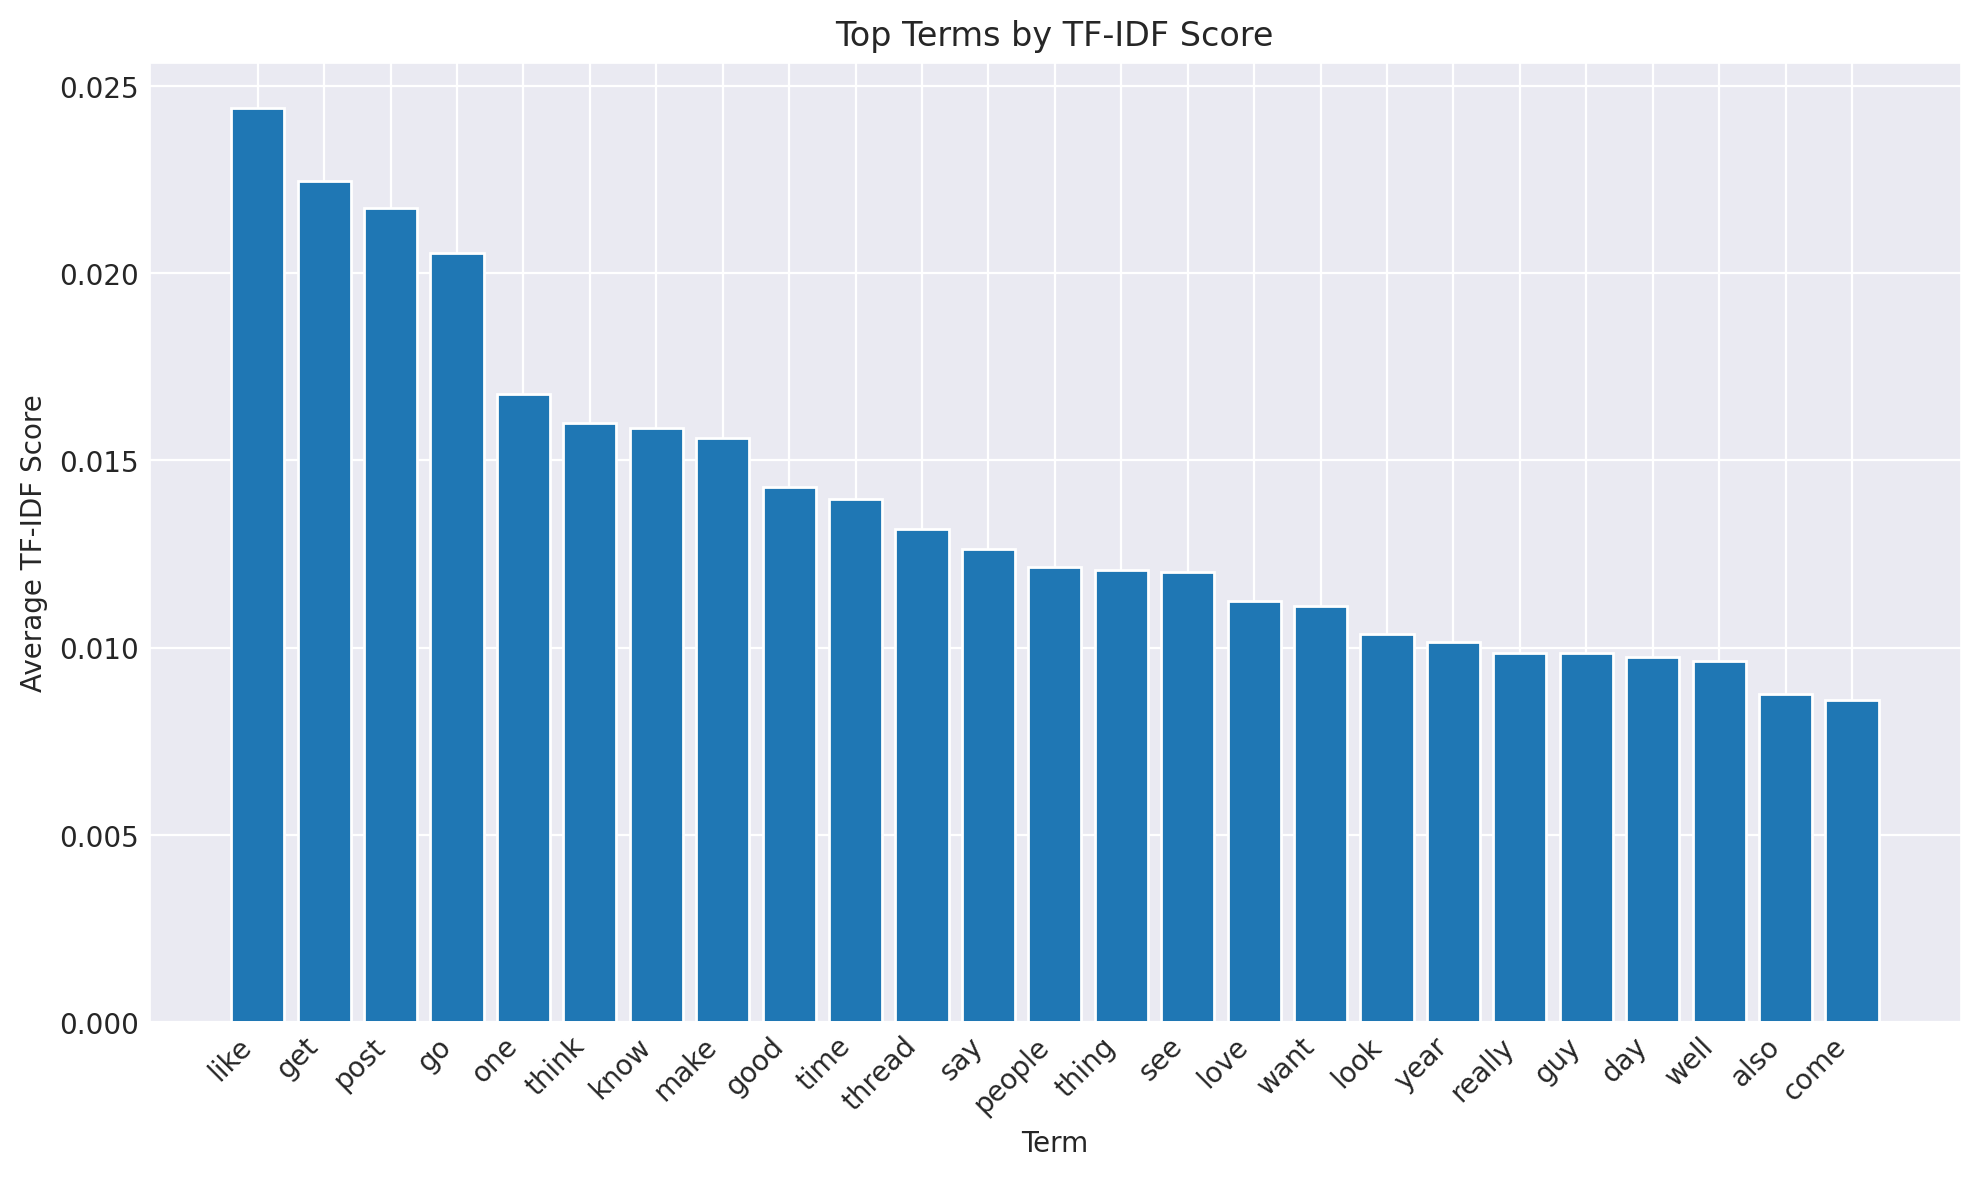

In [ ]:
# Compute average TF-IDF score for each term
avg_tfidf_scores = tfidf_matrix.mean(axis=0)

# Convert the matrix to a 1D array
avg_tfidf_scores = avg_tfidf_scores.A1

# Get indices of top-N terms with highest TF-IDF scores
top_n = 25
top_term_indices = avg_tfidf_scores.argsort()[::-1][:top_n]

# Get corresponding terms
terms = tfidf_vectorizer.get_feature_names_out()

# Plot bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), avg_tfidf_scores[top_term_indices], tick_label=[terms[i] for i in top_term_indices])
plt.xlabel('Term')
plt.ylabel('Average TF-IDF Score')
plt.title('Top Terms by TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The TF-IDF scores can be used to plot a wordcloud of the whole dataset. Please NOTE that **the biggest word will be the most important because will be the most discriminative** (appear a lot in specific documents but rarely accross the majority of them).

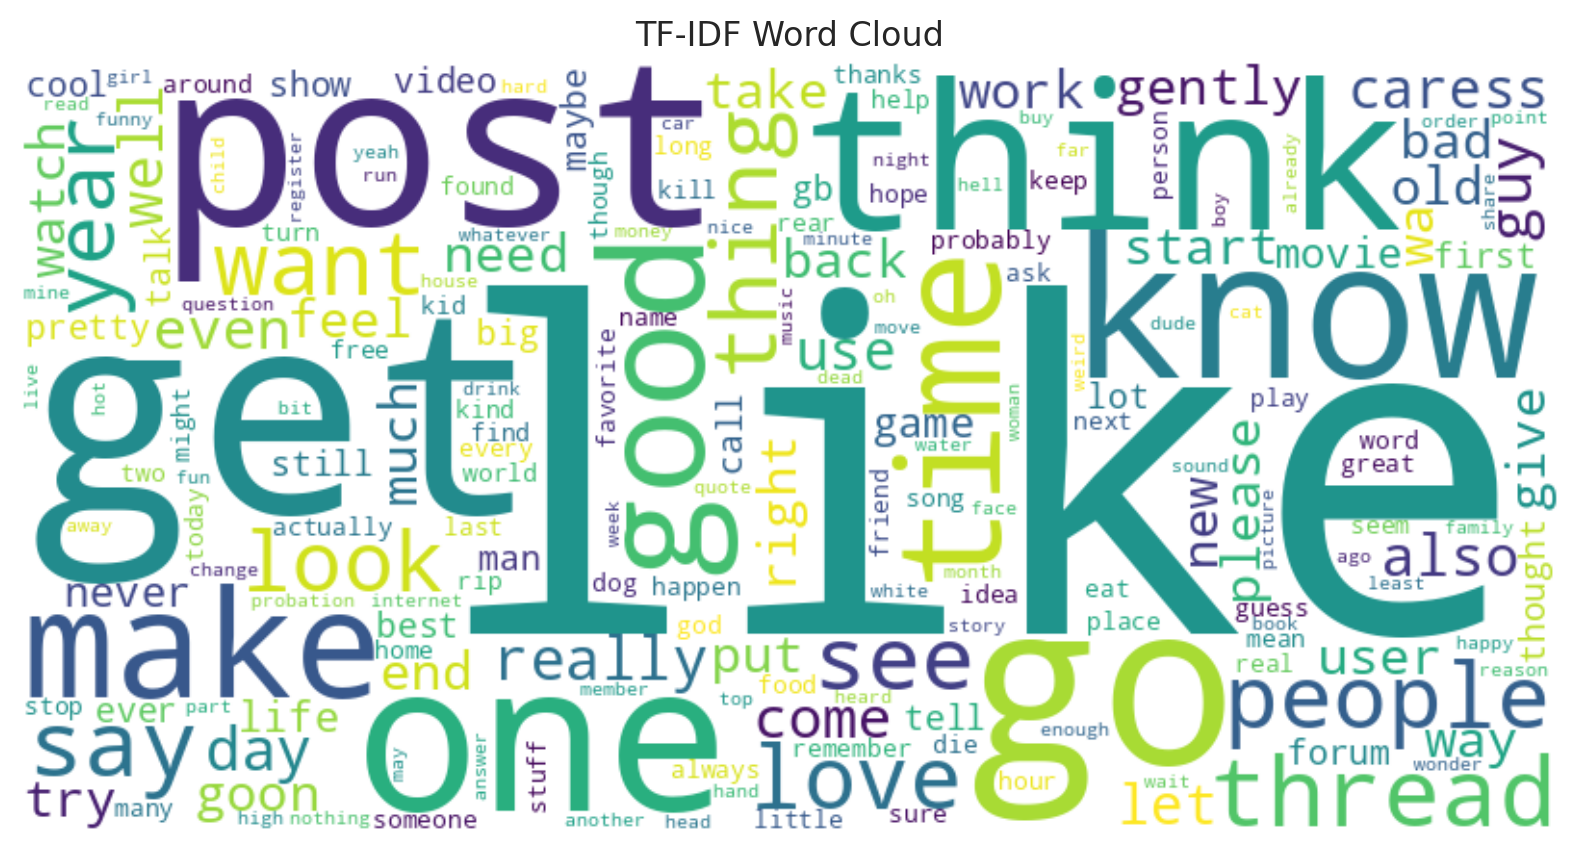

In [ ]:
# Word Cloud for TF-IDF
def plot_wordcloud(tfidf_matrix, feature_names):
    tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).ravel()
    word_freq = dict(zip(feature_names, tfidf_scores))
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('TF-IDF Word Cloud')
    plt.show()

# Visualize TF-IDF word cloud
feature_names = tfidf_vectorizer.get_feature_names_out()
plot_wordcloud(tfidf_matrix, feature_names)

TF-IDF matrices are typically large and sparse, especially when dealing with a large vocabulary and a large number of documents. SVD is well-suited for handling sparse matrices efficiently.

SVD, when applied to TF-IDF matrices, can help in identifying the latent semantic dimensions between terms and documents.

Furthermore, TruncatedSVD allows for dimensionality reduction by retaining only the most significant singular vectors/components of the matrix. This is particularly useful for reducing the dimensionality of TF-IDF matrices while preserving the most important information.

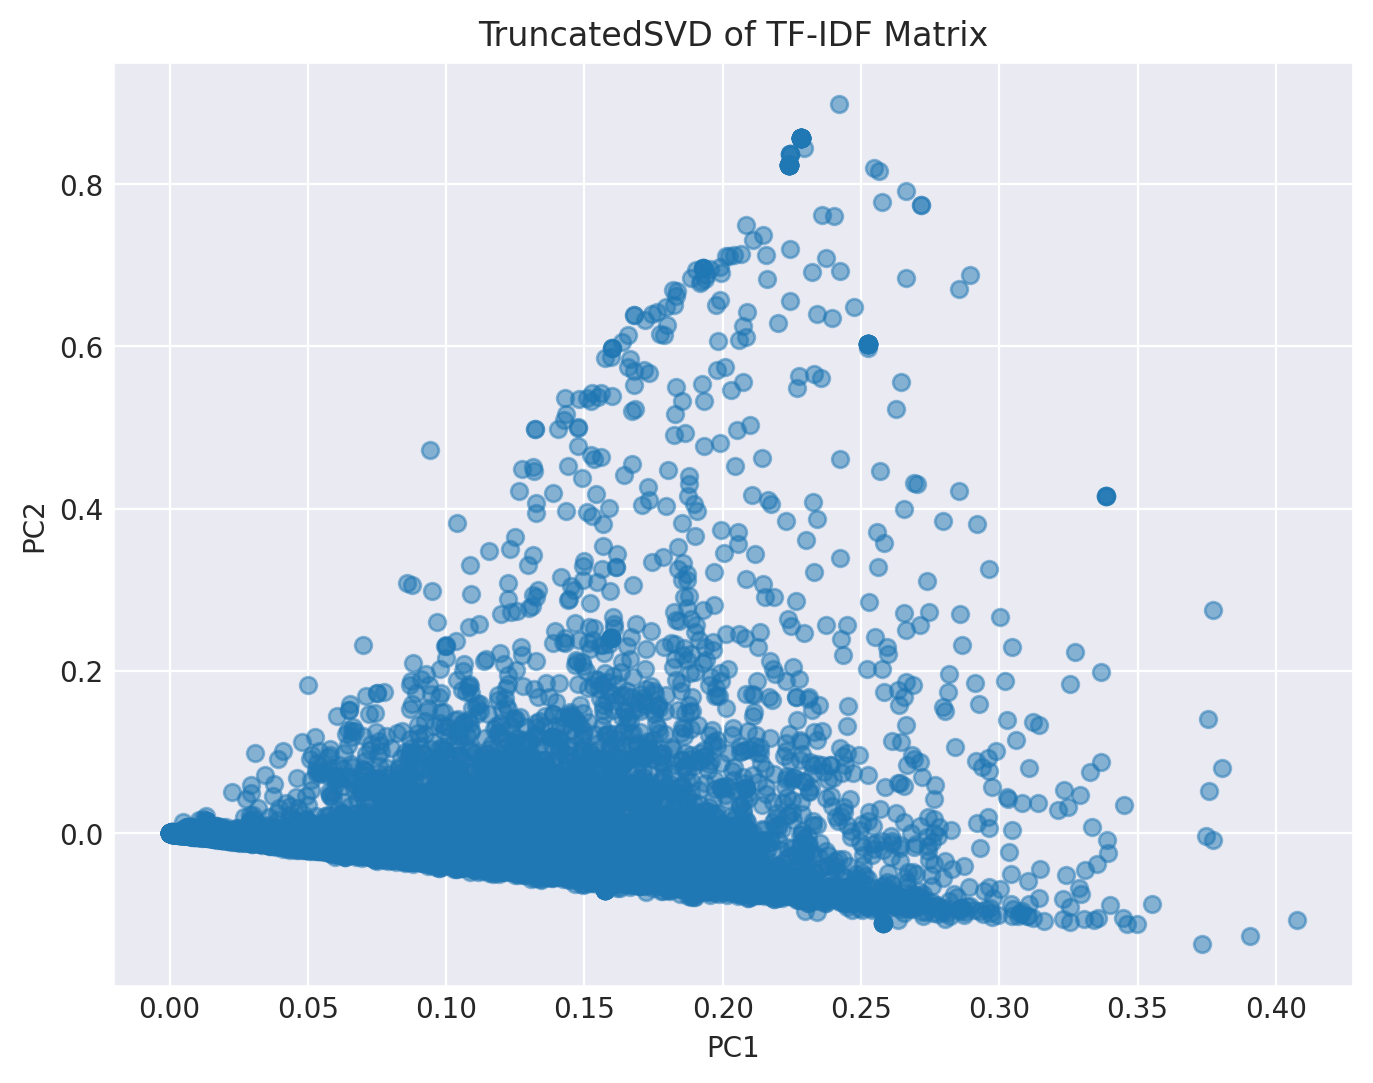

In [ ]:
# Perform TruncatedSVD (2D)
svd = TruncatedSVD(n_components=2)
tfidf_svd = svd.fit_transform(tfidf_matrix)

# Plot SVD result
plt.scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], alpha=0.5)
plt.title('TruncatedSVD of TF-IDF Matrix')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Saving TF-IDF matrix and SVD for dashboard usage

In [ ]:
# Save TruncatedSVD object
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd, f)

# Convert it to a sparse matrix if it's not already sparse
tfidf_sparse = sparse.csr_matrix(tfidf_matrix)

# Save the sparse matrix
sparse.save_npz('tfidf_matrix.npz', tfidf_sparse)

### Glove


GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for obtaining vector representations (word embeddings) of words in a continuous vector space. These word embeddings capture semantic relationships between words based on their co-occurrence statistics in a corpus of text.

Preloading a GloVe model allows users to directly access high-quality word embeddings without the need to train the model themselves.

In [ ]:
glove = downloader.load(x'glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


**How do we conver a set of words vectors into a document vectorization?**

*topic_embeddings_glove* converts sets of word vectors into document vectorizations using GloVe embeddings by iterating through tokenized text data, extracting word vectors for each token from the GloVe embeddings model, computing the mean of these word vectors to generate a single vector representation for each document or topic, handling out-of-vocabulary tokens by assigning random embeddings when necessary, and returning the list of document embeddings representing the topics.

In [ ]:
def topic_embeddings_glove(topic_tokens, glove):
    """
    Compute embeddings for each topic using GloVe embeddings.

    Parameters:
    - topic_tokens (list of lists): Tokens for each topic.
    - glove (GloVe model): Pre-trained GloVe word embeddings model.

    Returns:
    - topic_embeddings (list of arrays): Embeddings for each topic.
    """
    topic_embeddings = []

    for topic in topic_tokens:
        embedding = []
        for token in topic:
            if token in glove:
                embedding.append(glove[token])
        if len(embedding) > 0:
            topic_embeddings.append(np.mean(embedding, axis=0))
        else:
            # Handle OOV tokens by assigning a random embedding
            topic_embeddings.append(np.random.rand(glove.vector_size))

    return topic_embeddings

In [ ]:
forum_tokens = forum['clean_post_text'].str.split().tolist()
forum_embeddings_glove = topic_embeddings_glove(forum_tokens, glove)



**Glove visual representation**


 GloVe embeddings are high-dimensional vectors (in our case, 300 dimensions), which can be difficult to visualize directly. PCA reduces the dimensionality of the embeddings while preserving the overall structure and relationships between them, making it easier to visualize and interpret. Well-trained embeddings should exhibit meaningful clusters and separations

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(forum_embeddings_glove)

Saving PCA in case it is needed in the Dashboard

In [ ]:
# Save PCA object
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

A plot of the PCA obtained 300 dimensions to 2) can be obtained.

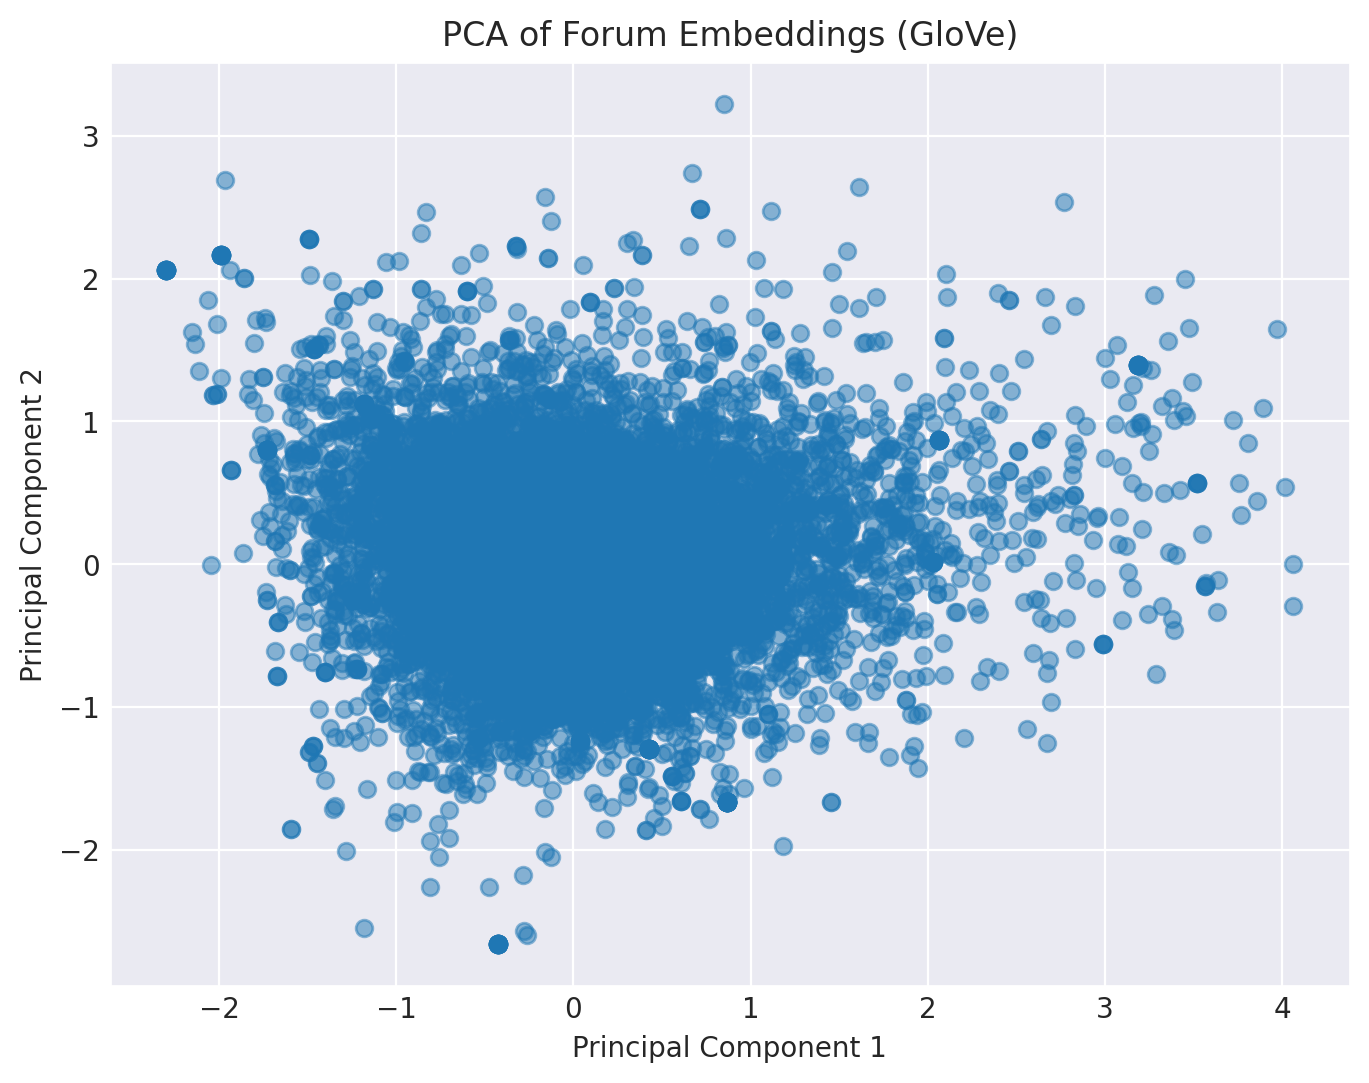

In [ ]:
# Scatter plot of PCA embeddings
plt.figure(figsize=(8, 6))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], alpha=0.5)
plt.title('PCA of Forum Embeddings (GloVe)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Therefore, we will be able to use TF-IDF SVDTruncated and Glove PCA to test  clustering.

### Extraction of themes and vector representation of the documents using the LDA algorithm (Mallet)


We will utilize Latent Dirichlet Allocation (LDA) to identify latent topics within a forum post corpus.

By Iterating over different numbers of topics, we will train LDA models using the Mallet toolkit, evaluating topic coherence using the c_v metric. The configuration with the highest coherence score is chosen as the best model, with corresponding model files saved for analysis.

Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 827
total tokens: 370017
<10> LL/token: -9.29674
<20> LL/token: -9.01928
<30> LL/token: -8.88924
<40> LL/token: -8.82922

0	1	time day love end back make thing feel good guy caress gently start work song rear kind bad pretty give 
1	1	year people quote work car time police home school report company call fire base space news told high accord month 
2	1	food dog eat people make american member big child white live animal run year register state man cat gun president 
3	1	post thread make thing good goon forum put user time people idea give word buy find free lot money store 
4	1	watch game show movie make video good guy time love people play year thing life remember film great book die 

<50> LL/token: -8.79565
<60> LL/token: -8.77022
<70> LL/token: -8.75093
<80> LL/token: -8.73895
<90> LL/token: -8.73032

0	1	time day love gently caress end back thing good guy feel work make rear start people give kind night ba

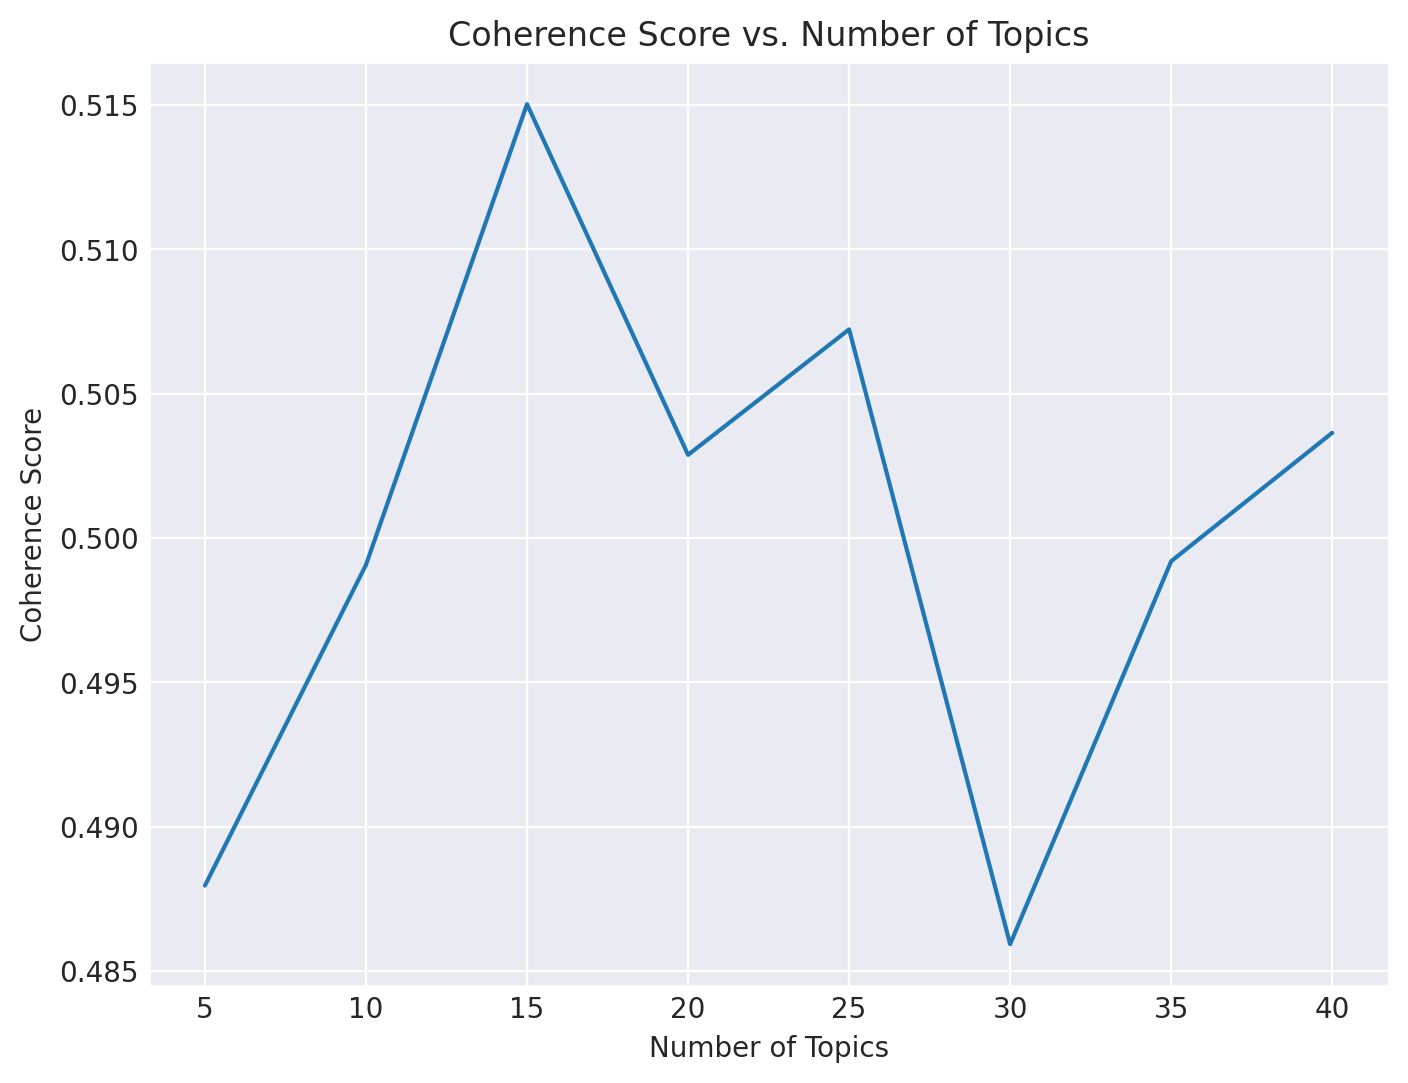

Best model found with 15 topics and coherence score of 0.5150257029078381.


In [ ]:
corpus = forum['clean_post_text'].tolist()

# Files to save in order to use it
best_model_files = {
    "mycorpus.mallet",
    "doc_topics.txt",
    "wtc_counts.txt",
    "topic_weights.txt",
    "topic_keys.txt"
}

num_topics_list = range(5, 41, 5)

coherence_values = []

best_coherence_score = -1

for num_topics in num_topics_list:
    # Export the corpus in Mallet format
    with open('mycorpus.txt', 'w') as f:
        for i, text in enumerate(corpus):
            f.write(f"{i} 0 {text}\n")

    # Train LDA
    !mallet-2.0.8/bin/mallet import-file --input mycorpus.txt --output mycorpus.mallet --keep-sequence --remove-stopwords
    !mallet-2.0.8/bin/mallet train-topics --input mycorpus.mallet --num-topics {num_topics} --num-iterations 100 \
        --output-doc-topics doc_topics.txt --word-topic-counts-file wtc_counts.txt --topic-word-weights-file \
        topic_weights.txt --output-topic-keys topic_keys.txt --num-top-words 20

    # Calculate topic coherence
    with open("topic_keys.txt") as fin:
        tpc_descriptions = fin.readlines()
        tpc_descriptions = [el.strip().split("\t")[-1].split() for el in tpc_descriptions]

    corpus_cohe = [el.strip().split() for el in corpus]
    D = Dictionary(corpus_cohe)

    # Number of words per topic to display
    n_words = 10

    cm = CoherenceModel(topics=tpc_descriptions, texts=corpus_cohe,
                        dictionary=D, coherence='c_v', topn=n_words)

    coherence_score = np.mean(cm.get_coherence_per_topic())
    coherence_values.append(coherence_score)

    # Save the model if it has the highest coherence score so far
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_model_num_topics = num_topics
        # Save the best model files
        best_model_path = f"best_model_num_topics_{num_topics}/"
        os.makedirs(best_model_path, exist_ok=True)
        for file in best_model_files:
            shutil.copyfile(file, best_model_path + file)

# Plotting
plt.plot(num_topics_list, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(num_topics_list)
plt.grid(True)
plt.show()

print(f"Best model found with {best_model_num_topics} topics and coherence score of {best_coherence_score}.")

In order to call again the best model (15 clusters, best coherence) we would need to access to the folder created with the files of it.

In [ ]:
# Define the directory containing the best model files
best_model_directory = "best_model_num_topics_15"  # Best model!

# Load each file
files = ["doc_topics.txt", "topic_keys.txt"]
loaded_files = {}

for file_name in files:
    file_path = os.path.join(best_model_directory, file_name)
    with open(file_path, 'rb') as file:
        try:
            # Try to decode the file using UTF-8
            loaded_files[file_name] = file.read().decode('utf-8')
        except UnicodeDecodeError:
            # If UTF-8 decoding fails, try other encodings
            print(f"Error decoding {file_name} with UTF-8 encoding. Trying different encodings...")
            encodings_to_try = ['latin1', 'utf-16', 'iso-8859-1']  # Add more encodings as needed
            for encoding in encodings_to_try:
                try:
                    loaded_files[file_name] = file.read().decode(encoding)
                    print(f"Decoded {file_name} with {encoding} encoding successfully.")
                    break
                except UnicodeDecodeError:
                    print(f"Failed to decode {file_name} with {encoding} encoding.")
            else:
                print(f"Unable to decode {file_name}.")
                loaded_files[file_name] = None

# Access the contents of each loaded file
# (commented ones are the ones we did not use at the end)

# mycorpus_mallet_content = loaded_files["mycorpus.mallet"]
doc_topics_content = loaded_files["doc_topics.txt"]
# wtc_counts_content = loaded_files["wtc_counts.txt"]
# topic_weights_content = loaded_files["topic_weights.txt"]
topic_keys_content = loaded_files["topic_keys.txt"]

Now it can be assigned a topic to each row of forum using doc_topics. This contains the probability of each row being in a topic.

In [ ]:
# Load the document-topic distribution
doc_topics_content = os.path.join(best_model_directory, "doc_topics.txt")
doc_topic_distributions = []

with open(doc_topics_content, 'r') as f:
    for line in f:
        # Split the line by tab and extract the topic distribution
        topic_distribution = [float(prob) for prob in line.strip().split("\t")[2:]]
        doc_topic_distributions.append(topic_distribution)

# Function to classify a document based on its topic distribution (maximum probability of it)
def classify_document(topic_distribution):
    return topic_distribution.index(max(topic_distribution))

# Apply the function to classify each document
forum["topic_number"] = [classify_document(topic_distribution) for topic_distribution in doc_topic_distributions]

We can retrieve the keys of our model like this, which may need some cleaning

In [ ]:
topic_keys_content

'0\t0.33333\tcar police home school told fire gun door house drive back road time kill run people child night story wild \n1\t0.33333\tgently caress thing love cool people stuff guy weird kind find make pretty guess dream lot day bad dude talk \n2\t0.33333\tstate quote american country year america vote people president world government accord war case attack official include force trump law \n3\t0.33333\twear back water face head hair hot black hole fat side large wall make big light color eye plant high \n4\t0.33333\tman year die woman wife love girl life day dead give death baby live animal black gay heart white god \n5\t0.33333\tmovie watch show film good make guy character star remember love story episode favorite great kid fan time funny season \n6\t0.33333\tgame video play song music time book year listen band team work back word sound album read start interest player \n7\t0.33333\tend time rear day good drink top feel back guy hat bad start bit stop long piss thing minute prett

In [ ]:
# Initialize an empty list to store cleaned topic strings
best_model_topic_keys = []

# Split the data into lines and iterate over each line
for line in topic_keys_content.split('\n'):
    # Split each line into parts
    parts = line.split('\t')
    if len(parts) == 3:
        # Extract the topic id and words from the line
        topic_id = parts[0]
        words = parts[2].split()

        # Remove any non-alphanumeric characters from words
        words = [word.strip() for word in words if word.isalpha()]

        # Join the words into a string separated by spaces
        topic_string = ' '.join(words)

        # Append the cleaned topic string to the list
        best_model_topic_keys.append(topic_string)

best_model_topic_keys

['car police home school told fire gun door house drive back road time kill run people child night story wild',
 'gently caress thing love cool people stuff guy weird kind find make pretty guess dream lot day bad dude talk',
 'state quote american country year america vote people president world government accord war case attack official include force trump law',
 'wear back water face head hair hot black hole fat side large wall make big light color eye plant high',
 'man year die woman wife love girl life day dead give death baby live animal black gay heart white god',
 'movie watch show film good make guy character star remember love story episode favorite great kid fan time funny season',
 'game video play song music time book year listen band team work back word sound album read start interest player',
 'end time rear day good drink top feel back guy hat bad start bit stop long piss thing minute pretty',
 'make year word thing people find good kid christmas internet thought time p

After making an analysis of the words of each topic, we decided to give it a main name in order to enhace interpretability.

In [ ]:
topic_mapping = {
    0: 'Crime',
    1: 'Wholesome',
    2: 'America Politics',
    3: 'Body',
    4: 'Family and Loss',
    5: 'Movie',
    6: 'Entertainment',
    7: 'Time',
    8: 'Memories',
    9: 'Work and Money',
    10: 'Life',
    11: 'Social Media',
    12: 'Forums',
    13: 'Food',
    14: 'Humanity'
}

forum['topic_interpretation'] = forum['topic_number'].map(topic_mapping)

In [ ]:
forum.head()

Post Title  \
0                     AI is an overblown mess right?   
1   bump this thread every time you take a huge shit   
2                                 ITT new user names   
3  Unpopular Videogame Opinions: A Midsummer's Ni...   
4                  Check out this snake's giant shit   

                                           Post Text  \
0  Its not going to change the world or even do ...   
1  i think my toilet knew what was coming. and pr...   
2  Post good as heck forum handles in case a lurk...   
3  DKC 3: Dixie's Double Trouble was better than ...   
4  .\nOnly registered members can see post attach...   

                                     clean_post_text  topic_number  \
0  go change world even useful right look like in...             8   
1                        think toilet knew come clog             1   
2  post good forum handle case lurker want finall...            12   
3  dixie double trouble well super world super el...             1   
4                register member see post attachment            12   

  topic_interpretation  
0             Memories  
1            Wholesome  
2               Forums  
3            Wholesome  
4               Forums

We will make an analysis of the topics obtained in the section related to emoji recommendation.

# Task 2: Machine Learning model: clustering

Clustering is a fundamental unsupervised learning technique to group similar data points together, allowing for a more structured understanding of complex datasets that are unlabeled.

The objective of clustering in this scenario is to create meaningful groupings of forum posts based on their textual content. These groupings will allow us to explore the variety of discussions occurring within the forum and identify overarching topics that connect different posts. This process can ultimately lead to a better understanding of the forum's structure and user behavior.


## Clustering with TF-IDF -> SVDTruncated -> K-means

Using the Trucated SVD of our TF-IDF, we will perform Kmeans, which partitions the data into a specified number of clusters.

We will iterate through different numbers of topics (clusters) and evaluate the clustering performance using  the **silhouette score**, which measures the cohesion and separation of clusters and the **inertia value** (for elbow method), which quantifies the compactness of clusters.

By evaluating clustering performance across different topics, we aim to determine the optimal number of clusters that best capture the underlying structure of the TF-IDF transformed data.

In [ ]:
# Initialize lists to store evaluation metrics
num_topics_list_tfidf = range(5, 101, 10)
silhouette_scores_tfidf = []
inertia_values_tfidf  = []

# Iterate through different numbers of topics
for num_topics in num_topics_list_tfidf:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_topics)
    kmeans.fit(tfidf_svd)
    clusters = kmeans.predict(tfidf_svd)

    # Calculate and append the metrics
    silhouette_avg = silhouette_score(tfidf_svd, clusters)
    silhouette_scores_tfidf.append(silhouette_avg)
    inertia_values_tfidf.append(kmeans.inertia_)

    # Print evaluation metrics
    print(f"Number of clusters: {num_topics}")
    print(f"Inertia: {kmeans.inertia_}")
    print(f"Silhouette Score: {silhouette_avg}")
    print("-" * 50)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 5
Inertia: 28.797999835906325
Silhouette Score: 0.46802016341868086
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 15
Inertia: 7.5884316140921335
Silhouette Score: 0.43516507896326717
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 25
Inertia: 4.352843727659359
Silhouette Score: 0.4169228038407537
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 35
Inertia: 3.00385785675903
Silhouette Score: 0.40890456240652456
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 45
Inertia: 2.295128398936858
Silhouette Score: 0.4001147823445242
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 55
Inertia: 1.8741488448519699
Silhouette Score: 0.3843863522895135
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 65
Inertia: 1.5875746340556773
Silhouette Score: 0.3655285944721163
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 75
Inertia: 1.3648012636241562
Silhouette Score: 0.3784353936498869
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 85
Inertia: 1.203578914885576
Silhouette Score: 0.37034402974746045
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 95
Inertia: 1.07048601710408
Silhouette Score: 0.3630180782183301
--------------------------------------------------


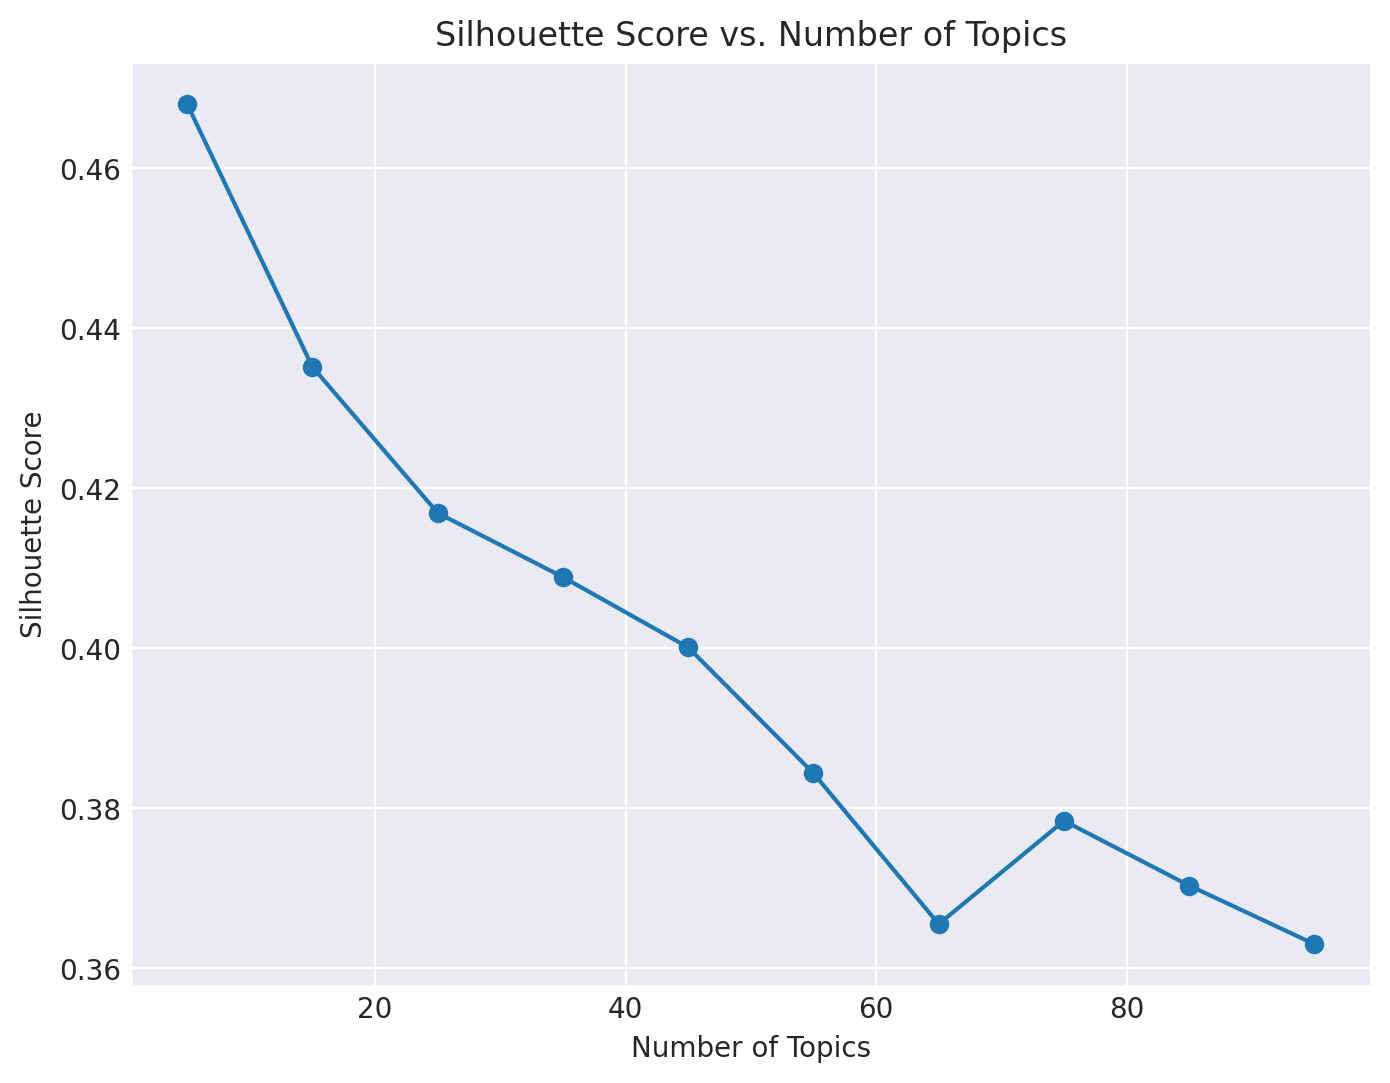

In [ ]:
# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(num_topics_list_tfidf, silhouette_scores_tfidf, marker='o')
plt.title('Silhouette Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

## Glove -> PCA -> K-means

Now, the same will be performed to our PCA obtained from Glove. The same scores as before will be saved for later comparison.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 5
Inertia: 4068.1156057577473
Silhouette Score: 0.31270206424166996
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 15
Inertia: 1610.5855075103955
Silhouette Score: 0.3146018079278194
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 25
Inertia: 996.0492026405896
Silhouette Score: 0.31609623424481276
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 35
Inertia: 713.0889790987319
Silhouette Score: 0.31703359922162283
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 45
Inertia: 551.8197346036943
Silhouette Score: 0.3227456165856607
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 55
Inertia: 446.3276671112602
Silhouette Score: 0.32403474279527766
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 65
Inertia: 374.6376355624368
Silhouette Score: 0.32509303801090783
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 75
Inertia: 324.1931772522302
Silhouette Score: 0.32398189489580526
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 85
Inertia: 286.5111744489931
Silhouette Score: 0.3235146231433162
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 95
Inertia: 257.80134770696293
Silhouette Score: 0.32553178964361096
--------------------------------------------------


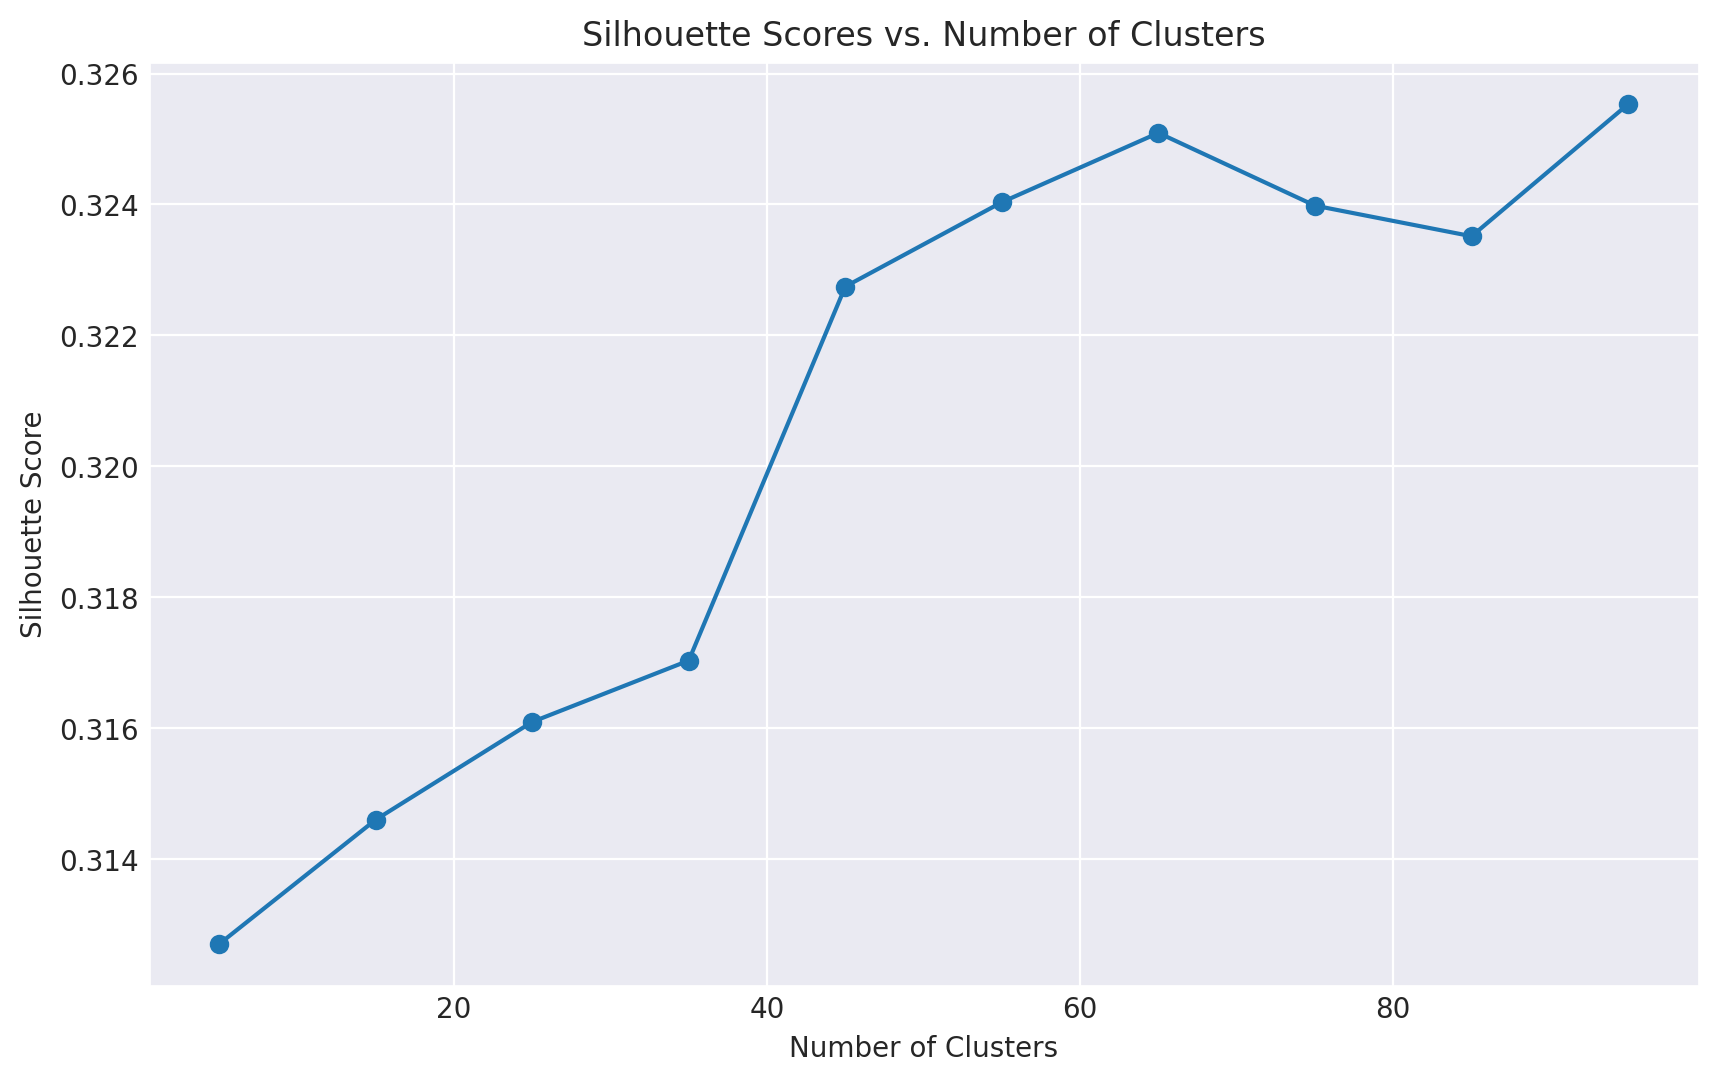

In [ ]:
# Define range of clusters
num_topics_list_glove = range(5, 101, 10)

# Initialize lists to store evaluation metrics
silhouette_scores_glove = []
inertia_values_glove  = []


# Iterate over different numbers of clusters
for num_clusters in num_topics_list_glove:
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_embeddings)

    # Compute evaluation metrics
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(pca_embeddings, cluster_labels)


    # Append metrics to lists
    inertia_values_glove.append(inertia)
    silhouette_scores_glove.append(silhouette_avg)


    # Print evaluation metrics
    print(f"Number of clusters: {num_clusters}")
    print(f"Inertia: {inertia}")
    print(f"Silhouette Score: {silhouette_avg}")
    print("-" * 50)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list_glove, silhouette_scores_glove, marker='o')
plt.title('Silhouette Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

## Comparison of the clusters

In order to compare and select the best technique for clustering, a dataframe with all the previously obtained metrics is created.

In [ ]:
clustering_results = {
    'Num Topics (TF-IDF)': list(num_topics_list_tfidf),
    'Silhouette Score (TF-IDF)': silhouette_scores_tfidf,
    'Inertia (TF-IDF)': inertia_values_tfidf,

    'Num Topics (GloVe)': list(num_topics_list_glove),
    'Silhouette Score (GloVe)': silhouette_scores_glove,
    'Inertia (GloVe)': inertia_values_glove,

}

clustering_results = pd.DataFrame(clustering_results)

We can easily plot the results in the dataframe.

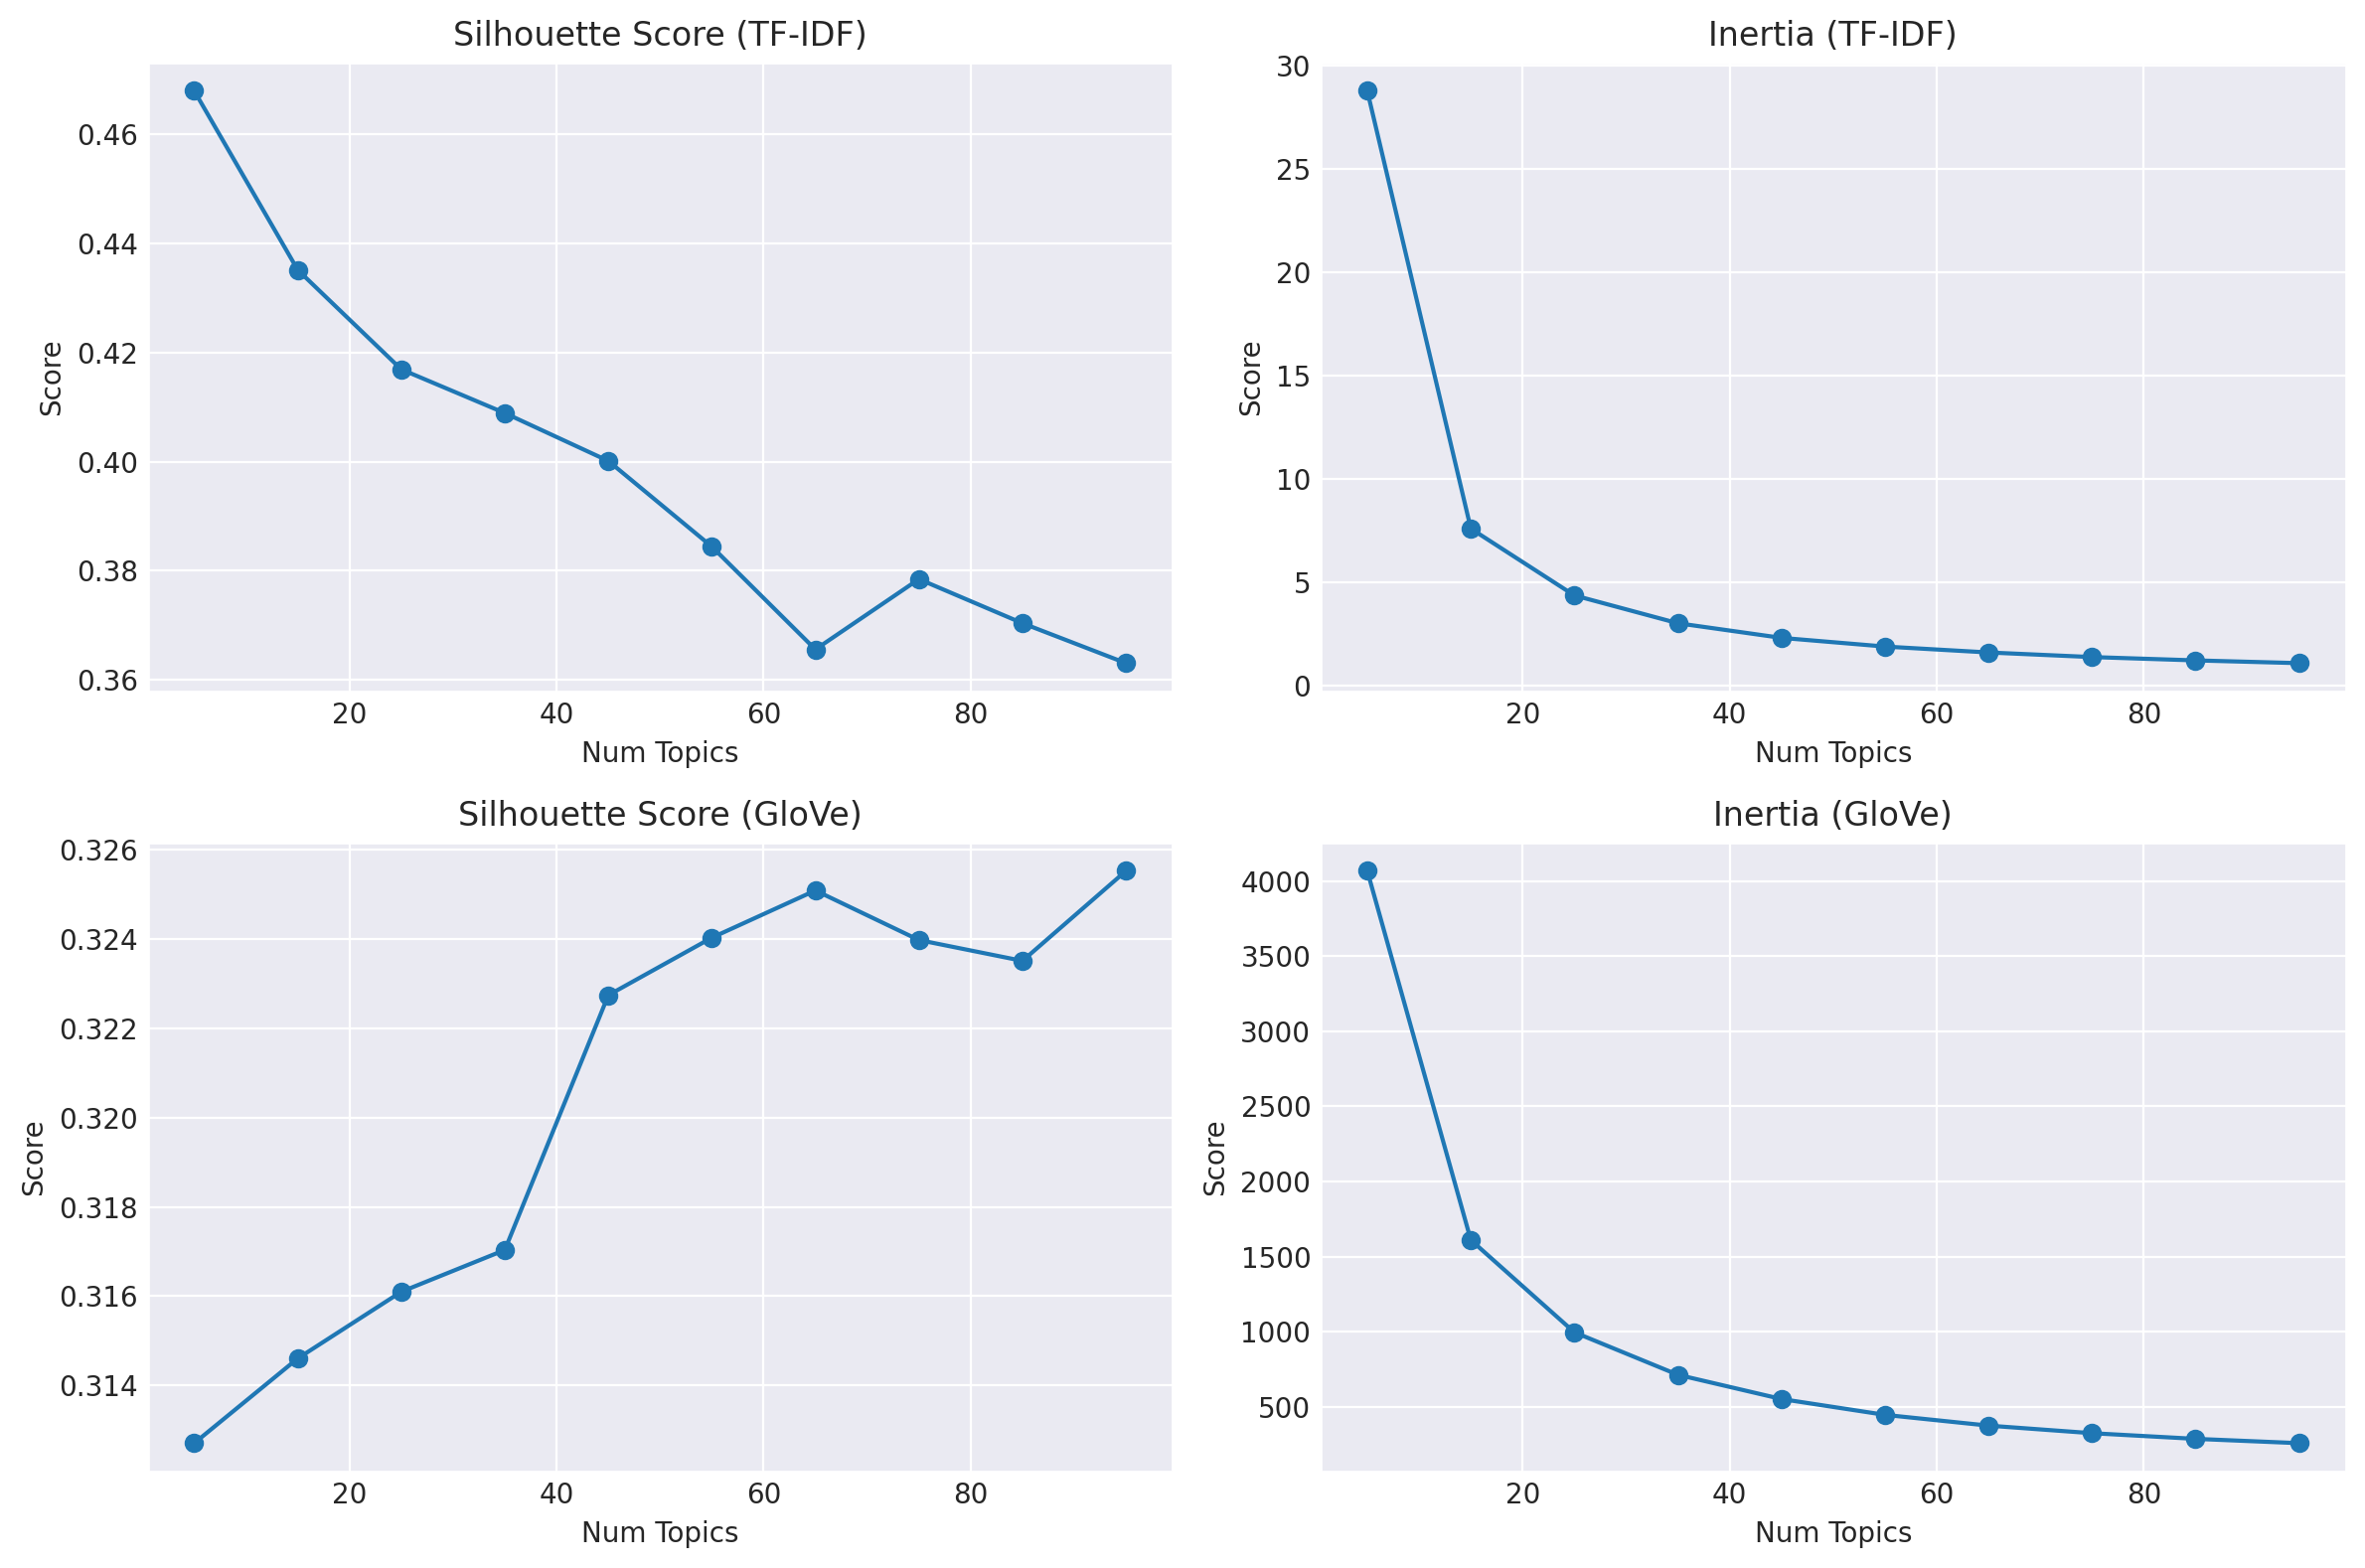

In [ ]:
# Get the number of topics
num_topics_tfidf = clustering_results['Num Topics (TF-IDF)']
num_topics_glove = clustering_results['Num Topics (GloVe)']

# Set up subplots for the required metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 'Silhouette Score' for TF-IDF
axes[0, 0].plot(num_topics_tfidf, clustering_results['Silhouette Score (TF-IDF)'], marker='o')
axes[0, 0].set_title('Silhouette Score (TF-IDF)')

# Plot 'Inertia' for TF-IDF
axes[0, 1].plot(num_topics_tfidf, clustering_results['Inertia (TF-IDF)'], marker='o')
axes[0, 1].set_title('Inertia (TF-IDF)')

# Plot 'Silhouette Score' for GloVe
axes[1, 0].plot(num_topics_glove, clustering_results['Silhouette Score (GloVe)'], marker='o')
axes[1, 0].set_title('Silhouette Score (GloVe)')

# Plot 'Inertia' for GloVe
axes[1, 1].plot(num_topics_glove, clustering_results['Inertia (GloVe)'], marker='o')
axes[1, 1].set_title('Inertia (GloVe)')

# Set common x and y labels
for ax in axes.flat:
    ax.set_xlabel('Num Topics')
    ax.set_ylabel('Score')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

In order to compare the metrics (silhouette scores and inertia ranges are very different) normalization is applied. We want both to have the same scale so that a weighted mean is computed among both metrics and compute a combine score that represents the effectiveness of that cluster.

In [ ]:
def min_max_normalize(column, min_val, max_val):
    return (column - min_val) / (max_val - min_val)

In [ ]:
# Apply min-max normalization to each column using its own min and max
for column in clustering_results.columns:
    if 'Num Topics' not in column:  # Skip normalization for 'Num Topics' columns
        min_val = clustering_results[column].min()
        max_val = clustering_results[column].max()
        clustering_results[column] = min_max_normalize(clustering_results[column], min_val, max_val)

We can now plot the metrics in the same plot as they are normalized.

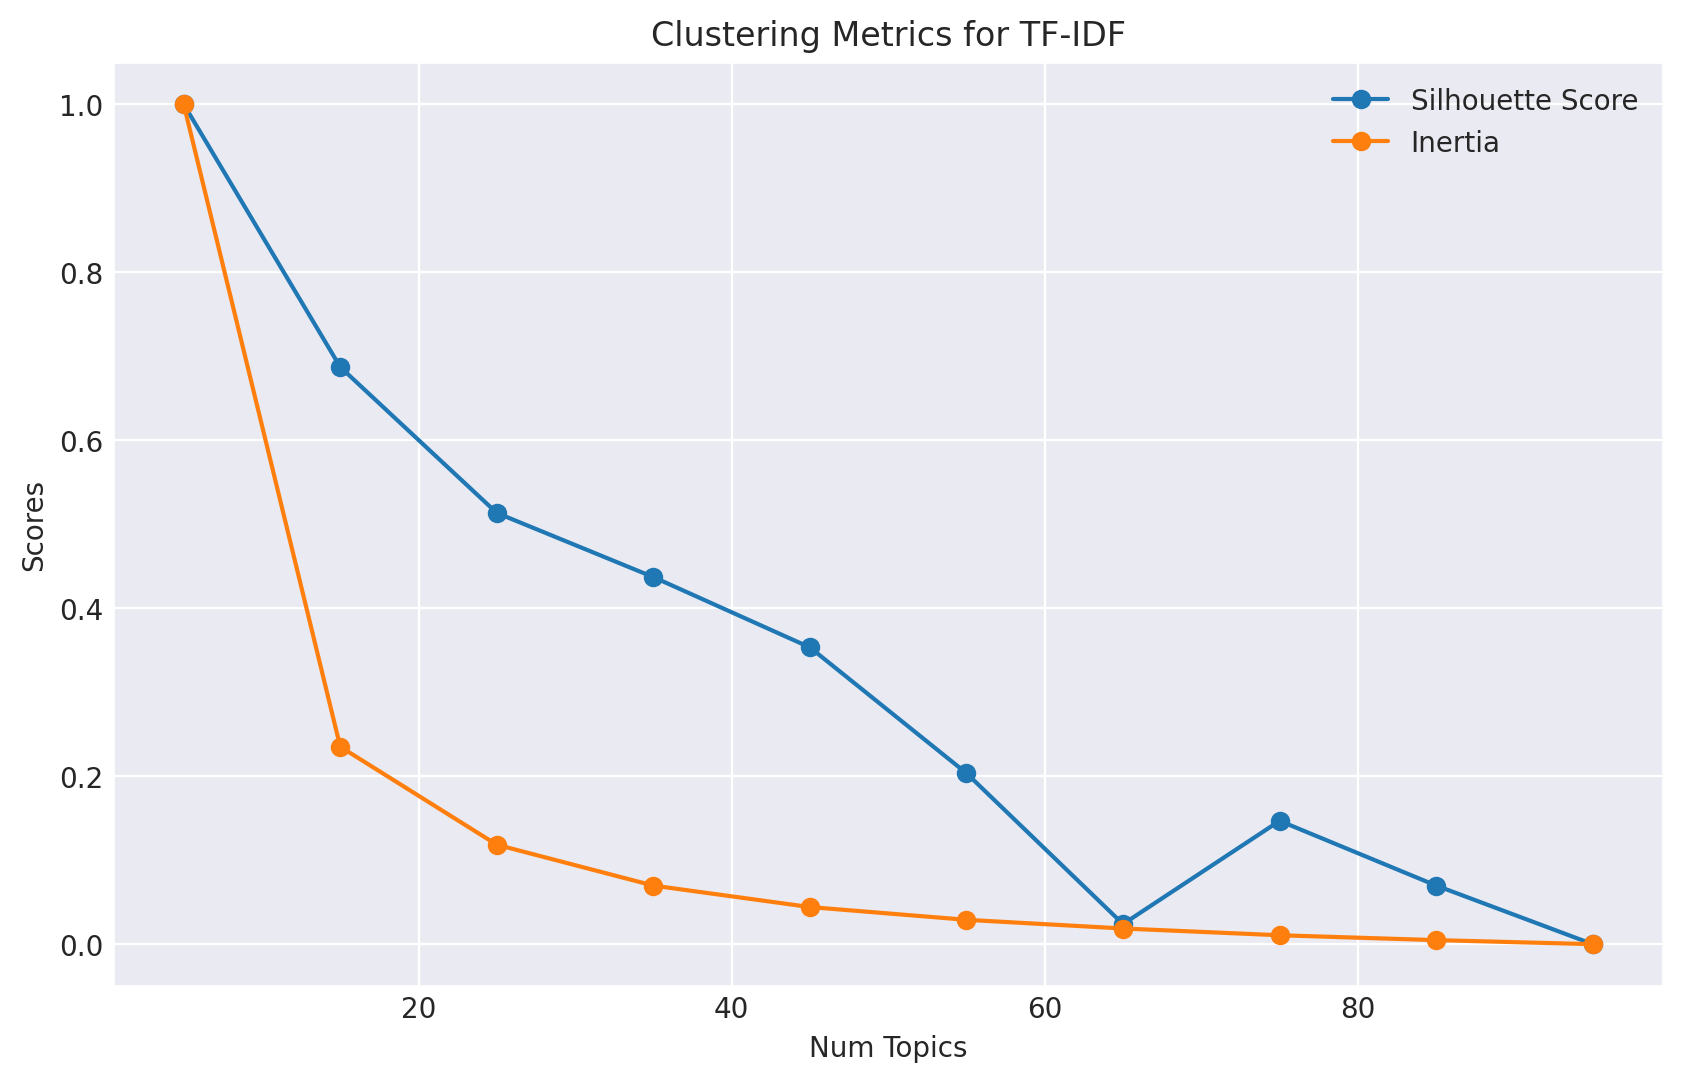

In [ ]:
# Get the number of topics and metrics for TF-IDF
num_topics_tfidf = clustering_results['Num Topics (TF-IDF)']
silhouette_scores_tfidf = clustering_results['Silhouette Score (TF-IDF)']
inertia_values_tfidf = clustering_results['Inertia (TF-IDF)']

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot each metric for TF-IDF
plt.plot(num_topics_tfidf, silhouette_scores_tfidf, marker='o', label='Silhouette Score')
plt.plot(num_topics_tfidf, inertia_values_tfidf, marker='o', label='Inertia')


# Set labels and title
plt.xlabel('Num Topics')
plt.ylabel('Scores')
plt.title('Clustering Metrics for TF-IDF')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

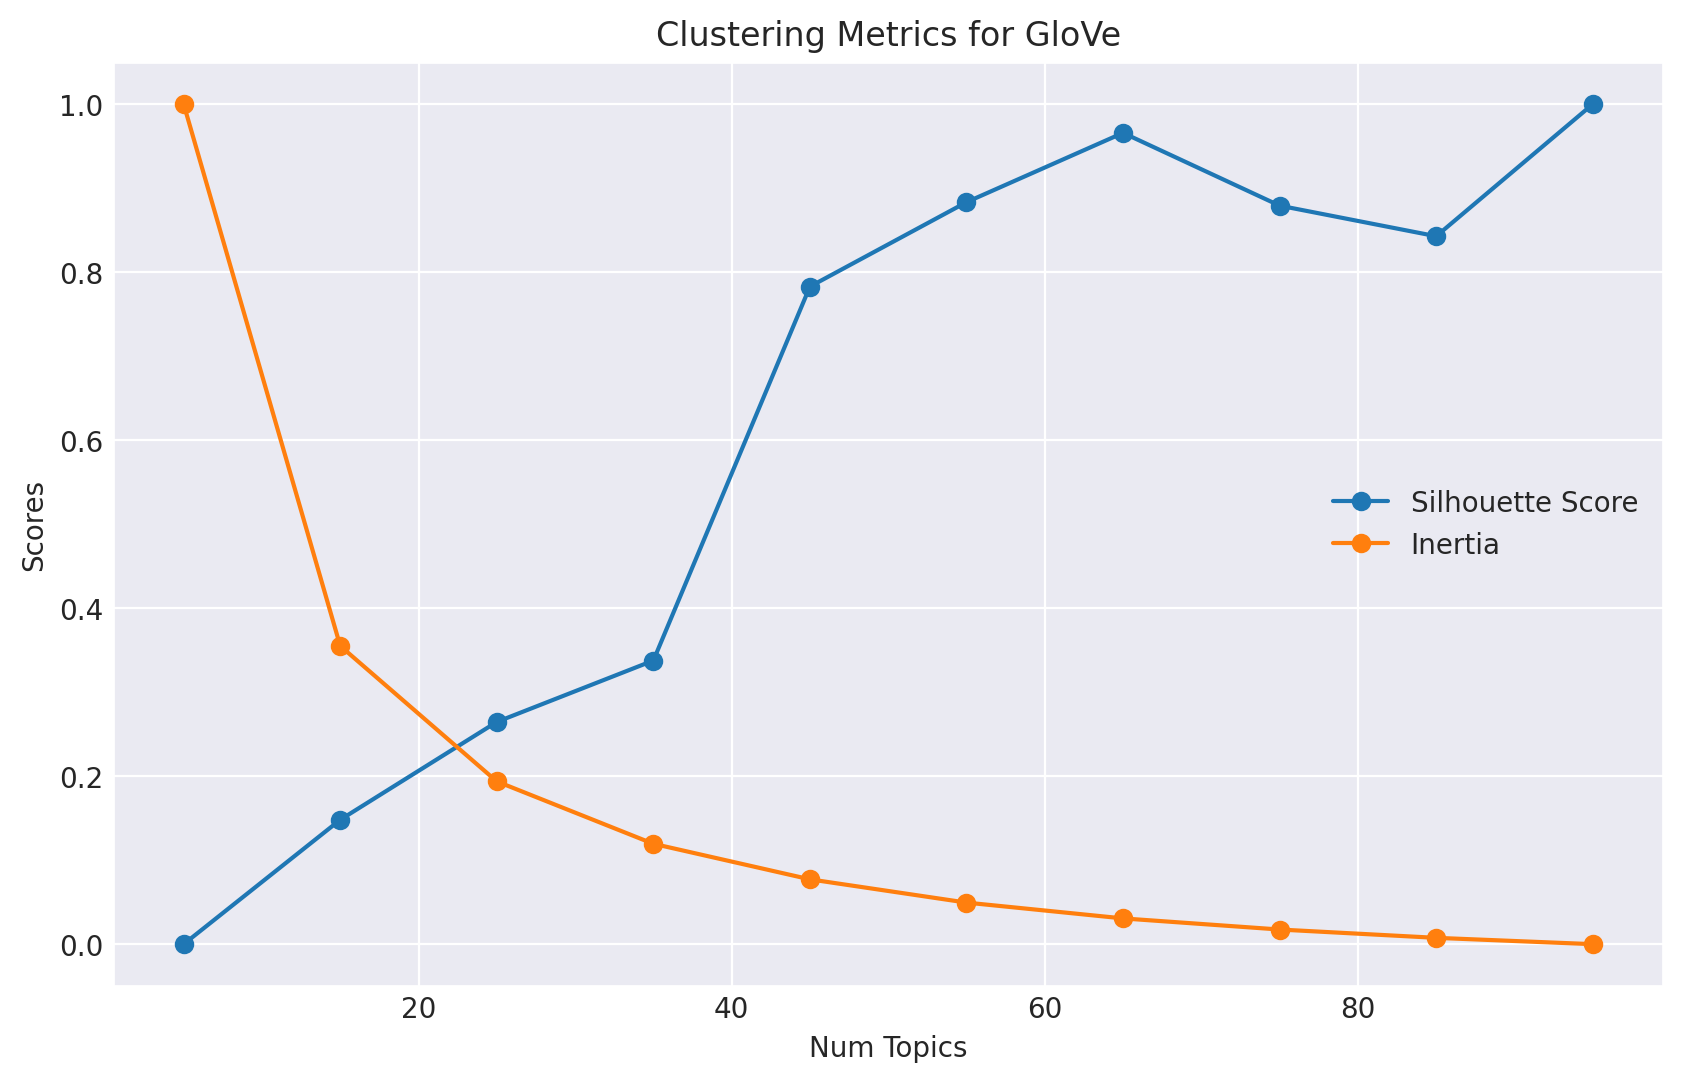

In [ ]:
# Get the number of topics and required metrics for GloVe
num_topics_glove = clustering_results['Num Topics (GloVe)']
silhouette_scores_glove = clustering_results['Silhouette Score (GloVe)']
inertia_values_glove = clustering_results['Inertia (GloVe)']

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot 'Silhouette Score' and 'Inertia' for GloVe
plt.plot(num_topics_glove, silhouette_scores_glove, marker='o', label='Silhouette Score')
plt.plot(num_topics_glove, inertia_values_glove, marker='o', label='Inertia')

# Set labels and title
plt.xlabel('Num Topics')
plt.ylabel('Scores')
plt.title('Clustering Metrics for GloVe')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Now, to compute the weighted mean to compute the combined score mentioned before, we must take into account that we want to maximize silhouette score (positive weight) and minimize intertia (negative score). We set 50% of weight to each metric becasue we did not wanted to priorize any of them.

In [ ]:
# Define weights for weighted mean
weights = {
    'Silhouette Score': 0.5,
    # minus becasue we want to minimize
    'Inertia': -0.5,
}

# Calculate combined score for each row (for TF-IDF and Glove)
clustering_results['Combined Score TFIDF'] = (clustering_results['Silhouette Score (TF-IDF)'] * weights['Silhouette Score']) + \
                                     (clustering_results['Inertia (TF-IDF)'] * weights['Inertia'])

clustering_results['Combined Score Glove'] = (clustering_results['Silhouette Score (GloVe)'] * weights['Silhouette Score']) + \
                                     (clustering_results['Inertia (GloVe)'] * weights['Inertia'])

In [ ]:
clustering_results

Num Topics (TF-IDF)  Silhouette Score (TF-IDF)  Inertia (TF-IDF)  \
0                    5                   1.000000          1.000000   
1                   15                   0.687101          0.235071   
2                   25                   0.513368          0.118379   
3                   35                   0.437005          0.069728   
4                   45                   0.353295          0.044167   
5                   55                   0.203503          0.028984   
6                   65                   0.023909          0.018649   
7                   75                   0.146829          0.010615   
8                   85                   0.069770          0.004800   
9                   95                   0.000000          0.000000   

   Num Topics (GloVe)  Silhouette Score (GloVe)  Inertia (GloVe)  \
0                   5                  0.000000         1.000000   
1                  15                  0.148074         0.355032   
2                  25                  0.264555         0.193750   
3                  35                  0.337617         0.119488   
4                  45                  0.782835         0.077164   
5                  55                  0.883314         0.049478   
6                  65                  0.965802         0.030663   
7                  75                  0.879195         0.017424   
8                  85                  0.842774         0.007535   
9                  95                  1.000000         0.000000   

   Combined Score TFIDF  Combined Score Glove  
0              0.000000             -0.500000  
1              0.226015             -0.103479  
2              0.197495              0.035403  
3              0.183639              0.109064  
4              0.154564              0.352835  
5              0.087260              0.416918  
6              0.002630              0.467569  
7              0.068107              0.430885  
8              0.032485              0.417620  
9              0.000000              0.500000

Obviously, to select the best number of clusters per technique, we needed to select the best score per column (15 for TF-IDF and 55 for Glove).

**How do we select among both?**

Recalling the inertia values of each method, and applying the elbow method, we obtain that 15 clusters are the most optimum number of clusters. We see that in fact, the 15 clusters of Glove have way lower score than 65, which is way more expensive than the 15 clusters of TF-IDF.

**Due to this reason, the method selected to continue with the cluster analysis is, TF-IDF -> SVDTruncated -> K-means (15 clusters)**

In [ ]:
# Extracting the best K-means
num_topics = 15

# Fit KMeans clustering model
kmeans = KMeans(n_clusters=num_topics)
kmeans.fit(tfidf_svd)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Exporting the best model for the Dashboard.

In [ ]:
# Export the KMeans model
with open('best_kmeans_model_15.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

For later usage, we will use a kmeans we have produced in another run of the notebook so it fits with our report and dashboard.

In [ ]:
# Load the KMeans model
kmeans = joblib.load('best_kmeans_model_15.pkl')

In [ ]:
# Fitting the clusters
clusters = kmeans.predict(tfidf_svd)
forum["clusters"] = clusters

As we have used SVD, we can save the coordinates of each forum post (point) for later plotting in the Dashboard.

In [ ]:
forum['SVD_Component_1'] = tfidf_svd[:, 0]
forum['SVD_Component_2'] = tfidf_svd[:, 1]

## Clustering interpretation

We can make some visual analysis to make an interpretations of the created clusters by our best model.

1) How does the SVD looks with our kmeans?

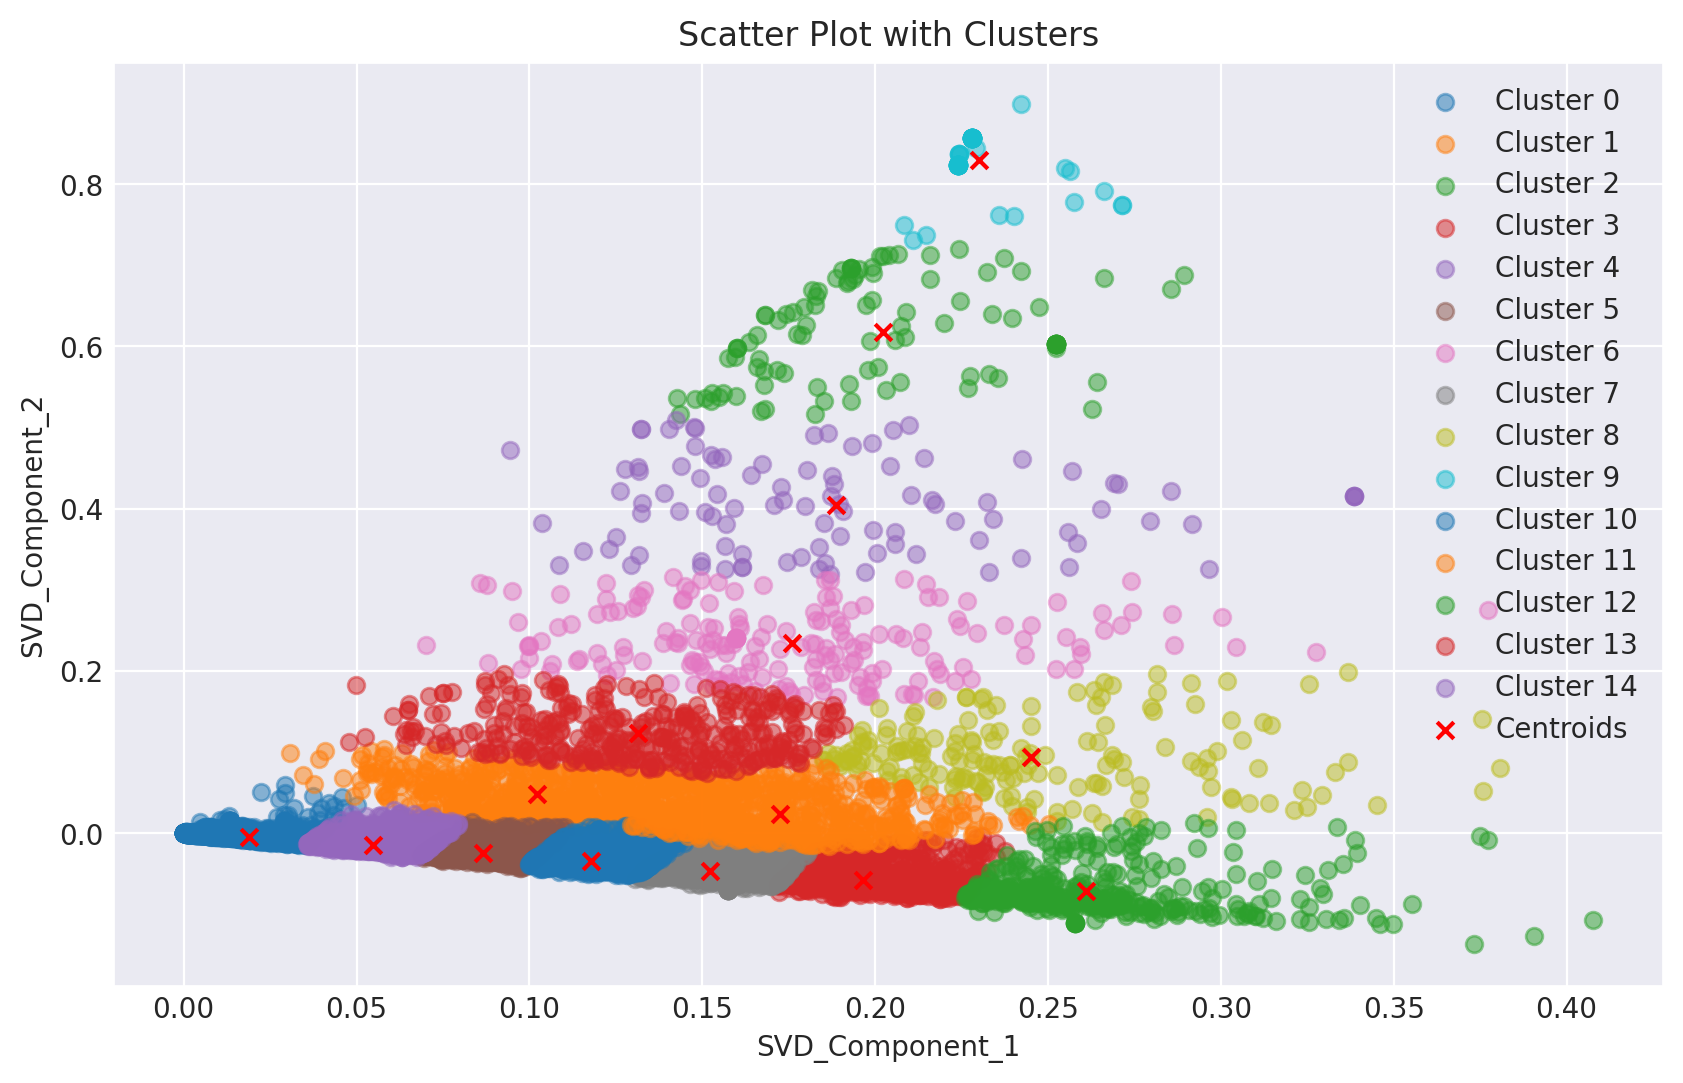

In [ ]:
import matplotlib.pyplot as plt

# Extracting data points
data_points = forum[['SVD_Component_1', 'SVD_Component_2']]
cluster_labels = kmeans.labels_

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
for i in range(len(centroids)):
    plt.scatter(data_points[cluster_labels == i]['SVD_Component_1'],
                data_points[cluster_labels == i]['SVD_Component_2'],
                label=f'Cluster {i}', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', label='Centroids')
plt.title('Scatter Plot with Clusters')
plt.xlabel('SVD_Component_1')
plt.ylabel('SVD_Component_2')
plt.legend()
plt.grid(True)
plt.show()

Note tha the clustering has been created with the SVDTruncated, so in fact it makes sense that it has used SVD components for the clustering.

2) Which words are more frequent per cluster?

In [ ]:
# Define a function to calculate document frequency (DF) for each word within each cluster
def calculate_document_frequency_by_cluster(forum, cluster_column, text_column):
    document_frequency_by_cluster = {}
    for cluster_id, group in forum.groupby(cluster_column):
        document_frequency = Counter()
        for text in group[text_column]:
            unique_words = set(word_tokenize(text))
            document_frequency.update(unique_words)
        document_frequency_by_cluster[cluster_id] = document_frequency
    return document_frequency_by_cluster

# Define a function to get the most repeated words for each cluster while filtering by document frequency
def most_repeated_words_by_cluster(forum, cluster_column, text_column, top_n=10, max_df=0.05):
    document_frequency_by_cluster = calculate_document_frequency_by_cluster(forum, cluster_column, text_column)
    most_common_words_by_cluster = {}
    for cluster_id, group in forum.groupby(cluster_column):
        word_counts = Counter()
        total_documents = len(group)
        for text in group[text_column]:
            tokens = word_tokenize(text)
            word_counts.update(tokens)
        # Filter out words with DF greater than max_df for the current cluster
        filtered_word_counts = Counter({word: count for word, count in word_counts.items()
                                        if document_frequency_by_cluster[cluster_id][word] / total_documents <= max_df})
        most_common_words = filtered_word_counts.most_common(top_n)
        most_common_words_by_cluster[cluster_id] = most_common_words
    return most_common_words_by_cluster

# Get the most repeated words for each cluster
most_repeated_words = most_repeated_words_by_cluster(forum, 'clusters', 'clean_post_text', top_n=10, max_df=0.05)

# Print the most repeated words for each cluster
for cluster_id, words in most_repeated_words.items():
    print(f"Cluster {cluster_id}:")
    for word, frequency in words:
        print(f"{word}: {frequency}")
    print()

Cluster 0:
rip: 102
street: 49
na: 41
pump: 39
bump: 39
fighter: 38
hype: 36
da: 34
sauce: 28
man: 27

Cluster 1:
quote: 32
video: 31
find: 31
may: 30
thought: 30
gb: 30
name: 29
game: 29
way: 28
really: 28

Cluster 2:
thanks: 5
rip: 4
people: 4
bye: 4
go: 4
gently: 4
caress: 4
want: 3
year: 3
one: 3

Cluster 3:
number: 144
quote: 97
school: 95
car: 93
woman: 90
book: 87
hand: 84
child: 82
food: 76
kill: 75

Cluster 4:
stop: 6
gently: 6
caress: 6
even: 5
high: 5
loses: 5
privilege: 5
good: 5
member: 4
banned: 4

Cluster 5:
end: 165
back: 162
two: 157
let: 153
thread: 152
give: 152
goon: 145
first: 144
bad: 142
call: 141

Cluster 6:
year: 13
gently: 12
caress: 12
please: 12
day: 11
video: 10
mod: 10
stop: 10
still: 9
thought: 9

Cluster 7:
eat: 145
quote: 136
car: 128
family: 126
found: 122
dog: 122
die: 121
kill: 121
idea: 120
food: 119

Cluster 8:
news: 19
space: 16
movie: 15
watch: 12
quote: 12
nothing: 12
become: 12
white: 11
tweet: 11
report: 11

Cluster 9:
b: 2
go: 2
n: 1
rip: 1
w

3) Which documents are the closest to each centroid?

This question is very useful to combine it with the previous one and obtain a general interpretation per cluster.

In [ ]:
# Extracting data points and centroids
data_points = forum[['SVD_Component_1', 'SVD_Component_2']]
centroids = kmeans.cluster_centers_

# Calculating distances and finding closest data points
closest_points_idx, _ = pairwise_distances_argmin_min(data_points, centroids)

# Grouping data points by cluster
cluster_texts = defaultdict(list)
for i, cluster_idx in enumerate(closest_points_idx):
    cluster_texts[cluster_idx].append(forum.iloc[i]['Post Text'])

# Printing top 10 texts closest to each centroid with labels
for cluster_idx, texts in cluster_texts.items():
    print(f"Cluster {cluster_idx} - Top 10 texts closest to centroid:")
    for i, text in enumerate(texts[:10], start=1):
        print(f"Text {i}: {text}")
    print()

Cluster 12 - Top 10 texts closest to centroid:
Text 1: Its not going to change the world or even do anything useful, right looks like the Internet of things from 10 years ago?
Text 2: This can be a cool thread where goons can post stuff they've been trying to find for years but have been unable to, like maybe the name of an old TV show, or a piece of media that they know exists but they cannot dig up, etc.
Mine is a short "film" that Sci-Fi channel used to show a lot in the mid to late 90s. It was called Suspicious and it starred Janeane Garofalo as a gas station clerk working the night shift. I remember it being a really creepy horror/thriller short. Here is the IMDB page for it:
https://www.imdb.com/title/tt0111324/
The director of the short used to have it on his YouTube page according to Google, but he has since deleted himself off YouTube. I've checked absolutely everywhere and have no idea how I can find this so that I may see it again. I'd really love to, if only so that I coul

After this, we came to this cluster topics:

- Cluster 0 consists of shorter, more cryptic messages.
- Cluster 1 revolves around a mix of content, with discussions mainly focused on forum content.
- Cluster 2 also groups together short messages that were banned with the message: (USER WAS AUTOBANNED FOR THIS POST)
- Cluster 3 focuses on food experiences and informal conversation sharing personal experiences and seeking advice.
- Cluster 4 has short texts in common as well as those that were banned with the message: (USER WAS AUTOBANNED FOR THIS POST)
- Cluster 5 seems to keep entrances related to groceries and food, but overall a mix of topics.
- Cluster 6 focuses on post contents and links.
- Cluster 7 reports many texts that involve life and loss.
- Cluster 8 does not fully involve forum entrances related to the same topic, it can be seen that it has entrances of people that were banned and others that focus on movies.
- Cluster 9 keeps posts in which users were put on probiotics with links , possibly indicating violations of forum rules or guidelines.
- Cluster 10 revolves around diverse topics. Despite this variety, there's a common idea related to different aspects of life, food and internet culture.
- Cluster 11 talks about audiovisual content.
- Cluster 12 has long texts in which it is mostly about the Internet and TV shows.
- Cluster 13 revolves around social media, posting and online communities.
- Cluster 14 talks mainly about news and video games but nothing very specific, these are very informal and short texts.


4) Do LDA topics and clusters have a similar distribution?

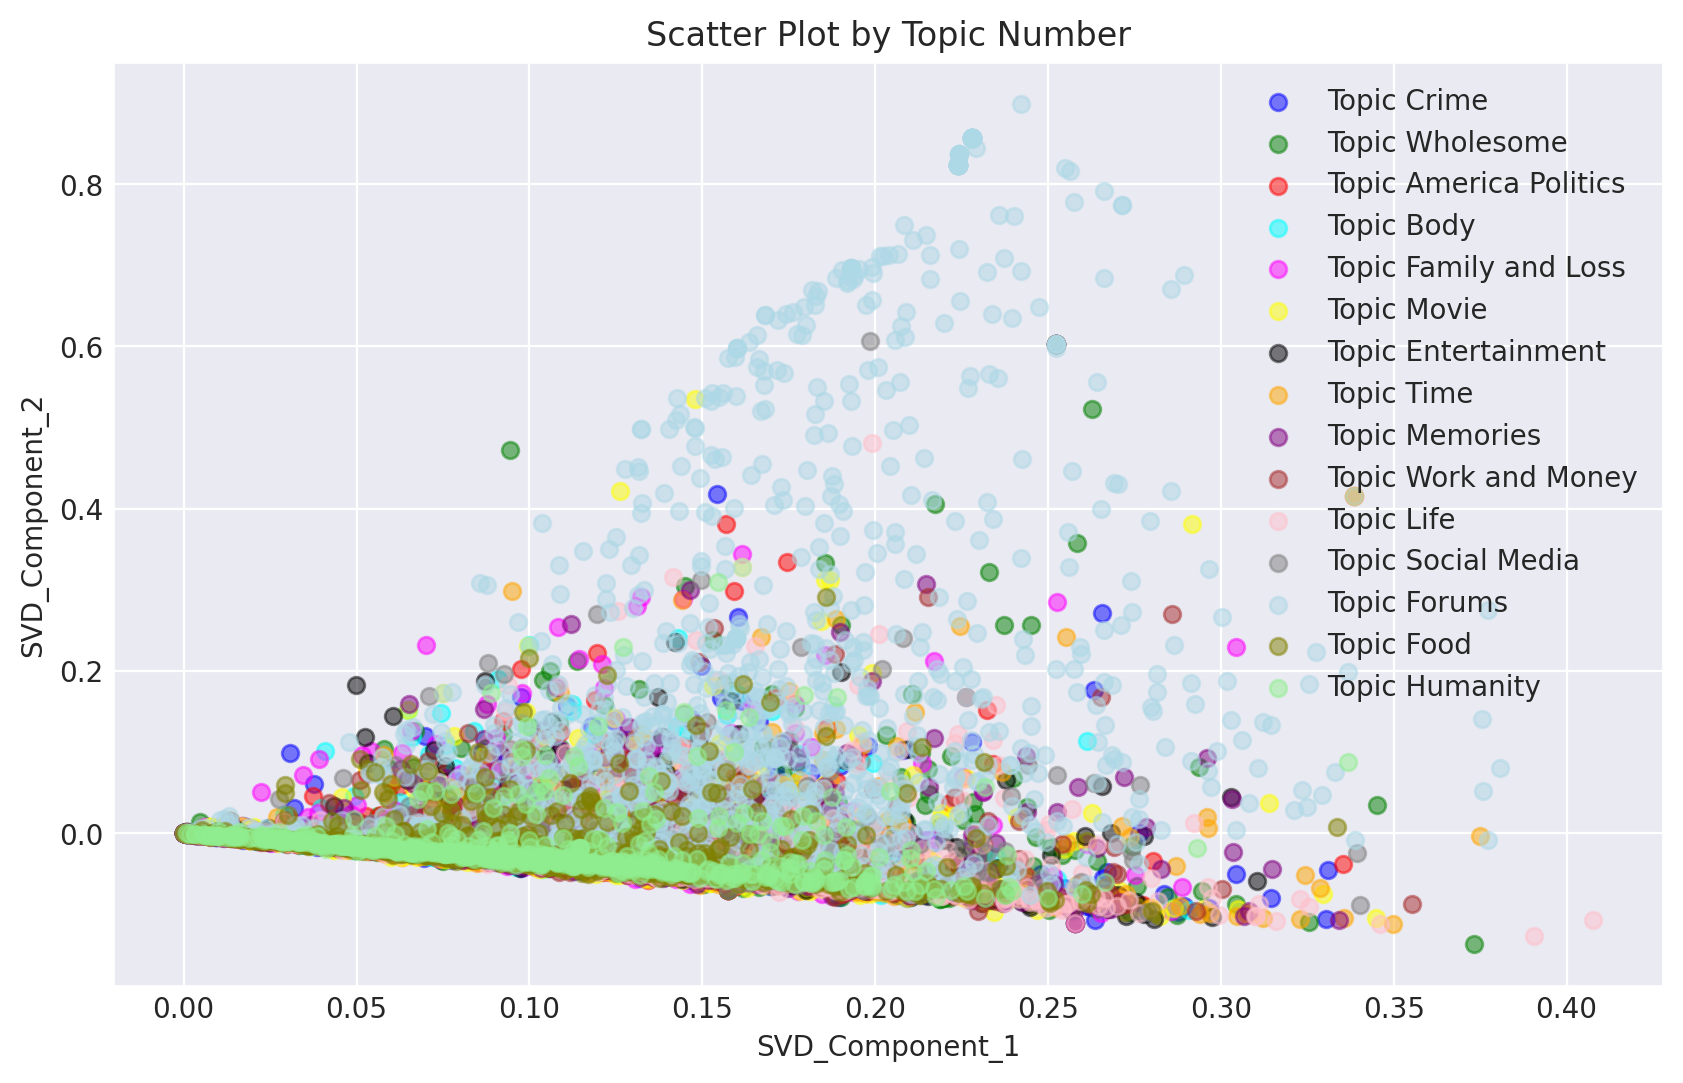

In [ ]:
# Extracting data points
data_points = forum[['SVD_Component_1', 'SVD_Component_2']]
topic_numbers = forum['topic_number']

# Define colors for each topic
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown', 'pink', 'gray', 'lightblue', 'olive', 'lightgreen']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
for i, topic_number in enumerate(sorted(topic_numbers.unique())):
    plt.scatter(data_points[topic_numbers == topic_number]['SVD_Component_1'],
                data_points[topic_numbers == topic_number]['SVD_Component_2'],
                label=f'Topic {topic_mapping[topic_number]}', alpha=0.5, color=colors[i % len(colors)])
plt.title('Scatter Plot by Topic Number')
plt.xlabel('SVD_Component_1')
plt.ylabel('SVD_Component_2')
plt.legend()
plt.grid(True)
plt.show()


We can see that humanity topic tends to have a SVD2 near 0. Furthermore, the same seems to happen with food topic. It is noticeable that forum topics is distributed all along the cluster, which makes sense as the posts are retrieved from a forum itself.

We can take out thosr three to see the rest of topics more clearly:

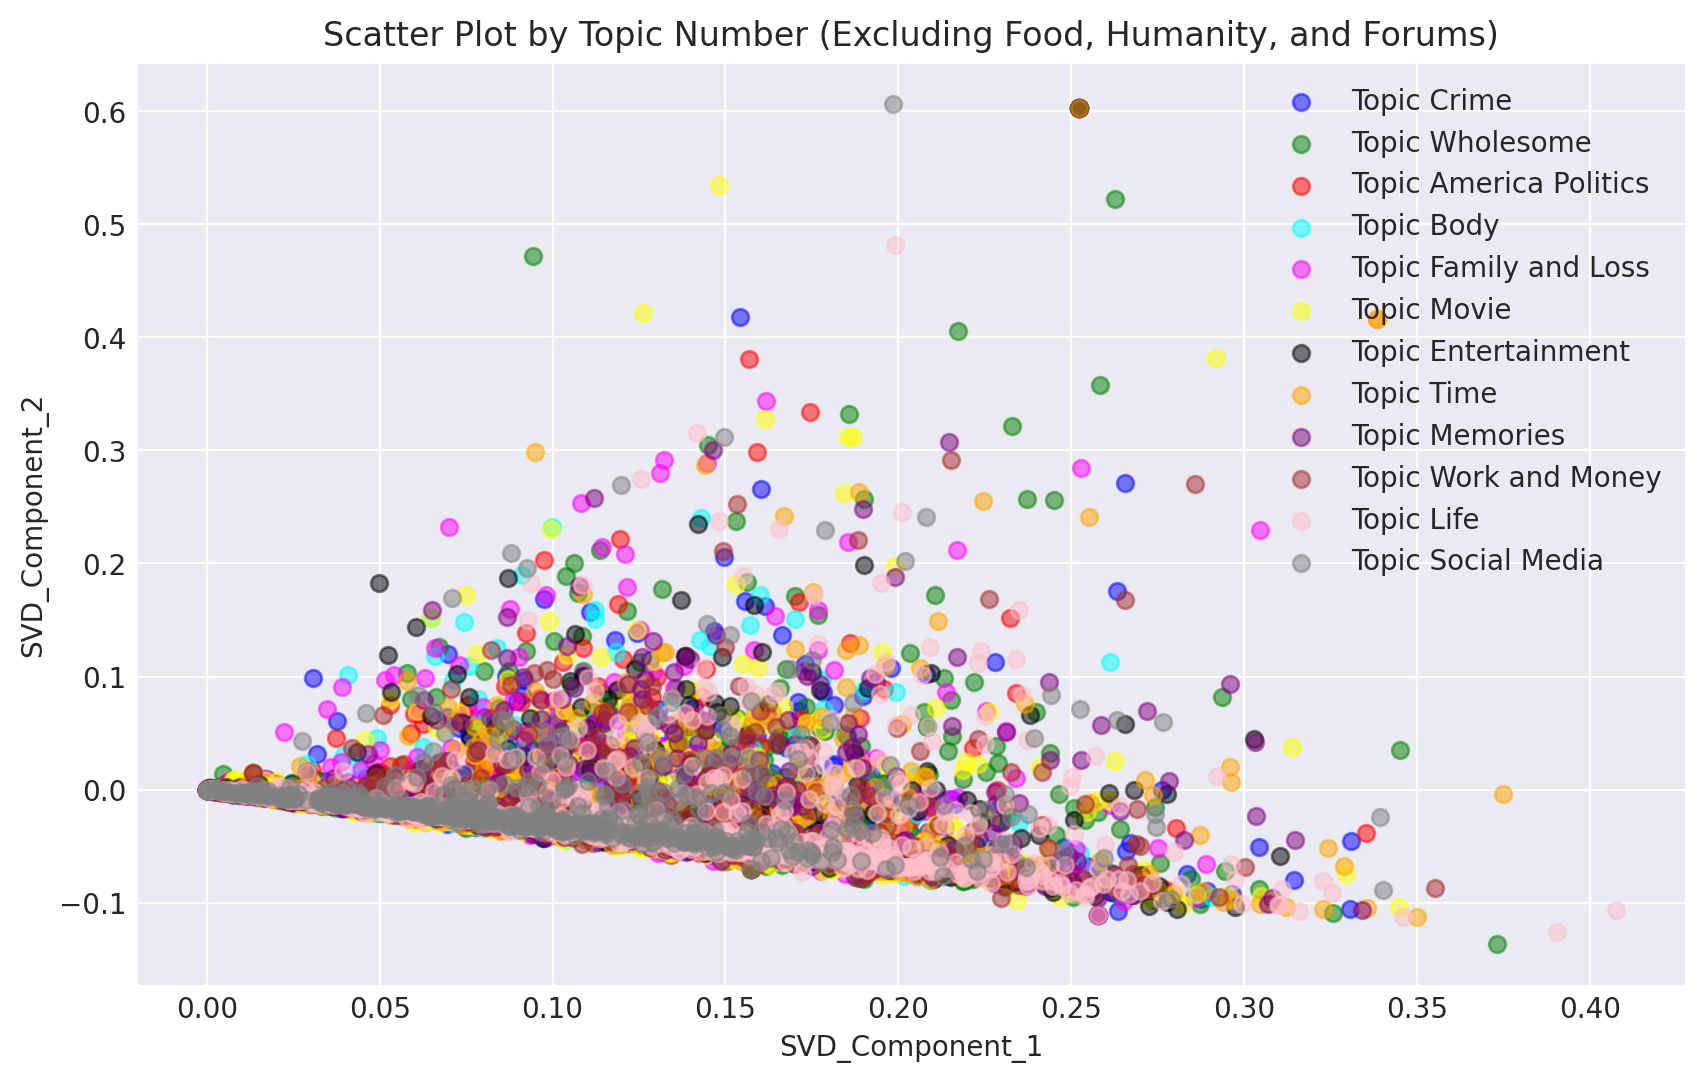

In [ ]:
import matplotlib.pyplot as plt

# Filter out topics "Food", "Humanity", and "Forums"
filtered_forum = forum[~forum['topic_interpretation'].isin(['Food', 'Humanity', 'Forums'])]

# Extracting data points
data_points = filtered_forum[['SVD_Component_1', 'SVD_Component_2']]
topic_numbers = filtered_forum['topic_number']

# Define colors for each topic
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown', 'pink', 'gray', 'lightblue', 'olive', 'lightgreen']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
for i, topic_number in enumerate(sorted(topic_numbers.unique())):
    plt.scatter(data_points[topic_numbers == topic_number]['SVD_Component_1'],
                data_points[topic_numbers == topic_number]['SVD_Component_2'],
                label=f'Topic {topic_mapping[topic_number]}', alpha=0.5, color=colors[i % len(colors)])
plt.title('Scatter Plot by Topic Number (Excluding Food, Humanity, and Forums)')
plt.xlabel('SVD_Component_1')
plt.ylabel('SVD_Component_2')
plt.legend()
plt.grid(True)
plt.show()


Again, there is a clear tendency of Social Media topics being close to 0 in SVD2, the same with Life. Despite this, it has more sparsity than the previous topics. In fact, if we continue taking out topics, we will see that many of thems follow a similar distribution but varying the sparsity.

**This leads to conclude that our topics of LDA and clusterings may not be related.**

Furthermore, this analysis can be later be continue with the sentiments and emojis.

# Sentiment analysis for emojis recommendations

The goal of this part is to recommend 3 emojis per post according to the sentiment analysis of both the emojis and the forum posts.

## Datasets loading

1) Emojis loading and cleaning

In [ ]:
path2data = local_folder / 'datasets' / 'full_emoji.csv'
emojis = pd.read_csv(path2data, usecols=['emoji','name'])

# Drop duplicates
emojis = emojis.drop_duplicates(subset = ["name"])
# There are NAs before starting cleaning!!
emojis = emojis[~emojis['name'].isna()]
# Cleaning the text
emojis['clean_name'] = emojis['name'].apply(clean_text)
# Drop rows that are empty after cleaning
emojis = emojis[emojis['clean_name'] != ""]
# Resetting indexes
emojis.reset_index(drop=True, inplace=True)

emojis.head()

emoji                             name           clean_name
0     😀                    grinning face            grin face
1     😃      grinning face with big eyes    grin face big eye
2     😄  grinning face with smiling eyes  grin face smile eye
3     😁   beaming face with smiling eyes  beam face smile eye
4     😆          grinning squinting face     grin squint face

2) Emotion NRC lexicon loading and cleaning

In [ ]:
path2data = local_folder / 'datasets' / 'NRC-Emotion-Lexicon.csv'

nrc_lexicon_df = pd.read_csv(path2data)

nrc_lexicon_df = nrc_lexicon_df.loc[:, ['English (en)', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']]

nrc_lexicon_df = nrc_lexicon_df[~nrc_lexicon_df['English (en)'].isna()]

nrc_lexicon_df['clean_name'] = nrc_lexicon_df['English (en)'].apply(clean_text)

nrc_lexicon_df = nrc_lexicon_df[nrc_lexicon_df['clean_name'] != ""]

nrc_lexicon_df.reset_index(drop=True, inplace=True)

nrc_lexicon_df.head()

English (en)  Anger  Anticipation  Disgust  Fear  Joy  Sadness  Surprise  \
0        aback      0             0        0     0    0        0         0   
1       abacus      0             0        0     0    0        0         0   
2      abandon      0             0        0     1    0        1         0   
3    abandoned      1             0        0     1    0        1         0   
4  abandonment      1             0        0     1    0        1         1   

   Trust   clean_name  
0      0        aback  
1      1       abacus  
2      0      abandon  
3      0      abandon  
4      0  abandonment

For sentiment analysis we will only use faces

In [ ]:
emojis_faces = emojis.loc[:98,]
print(len(emojis))
print(len(emojis_faces))

1788
99


## Sentiment scores calculations

This function is the most demanding of the notebook. It is used to provide a dictionary with the count of words that have a feeling.

In [ ]:
def calculate_emotional_scores(tokens):
    """
    Calculate emotional scores for a list of tokens using an emotion lexicon DataFrame.

    Args:
    - tokens (list): A list of tokens (words) extracted from text data.

    Returns:
    - emotional_scores (dict): A dictionary containing emotional scores for each emotion in the lexicon.
                                Keys represent emotions, and values represent cumulative scores.
    """
    # Initialize emotional scores
    emotional_scores = {emotion: 0 for emotion in nrc_lexicon_df.columns[1:] if emotion != 'clean_name'}
    tokens = wordpunct_tokenize(tokens)

    # Calculate emotional scores
    for token in tokens:
        # Check if the token appears in the 'clean_name' column of the lexicon DataFrame
        matched_words = nrc_lexicon_df[nrc_lexicon_df['clean_name'] == token]
        if not matched_words.empty:
            # Iterate over the matched words and accumulate emotional scores
            for _ , word_row in matched_words.iterrows():
                for emotion in emotional_scores:
                    # Convert the emotion score to numeric type before adding it
                    emotion_score = pd.to_numeric(word_row[emotion], errors='coerce')
                    if not pd.isnull(emotion_score):
                        emotional_scores[emotion] += emotion_score
    return emotional_scores

In [ ]:
emojis_faces['emotional_scores'] = emojis_faces['clean_name'].apply(lambda x: calculate_emotional_scores(x))
forum['emotional_scores'] = forum['clean_post_text'].apply(lambda x: calculate_emotional_scores(x))

<ipython-input-80-1cd78d793a51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emojis_faces['emotional_scores'] = emojis_faces['clean_name'].apply(lambda x: calculate_emotional_scores(x))


In order to compare forum and emojis texts that have very different lengths (leading to different scores) we needed to scale.

In order to do that, we calculated the total count of emotions and dividing by it in their corresponding dataset.

Furthermore, as you will se later, we created a pipeline for new text emoji recommendation. To scale the sentiments of that text we needed to treat it as a new forum text and that is why we save the total_emotions dictionary.

In [ ]:
def scale_emotional_scores(emotional_scores, total_emotions=None):
    """
    Scale emotional scores to ensure comparability between datasets.

    Args:
    - emotional_scores (list of dicts): A list of dictionaries containing emotional scores for each text or dataset.
    - total_emotions (dict, optional): A dictionary containing the total count of emotions across all texts or datasets.
                                       If not provided, the function calculates the total count of emotions from the
                                       provided emotional_scores.
    Returns:
    - total_emotions (dict): A dictionary containing the total count of emotions across all texts or datasets.
    - scaled_emotional_scores (list of dicts): A list of dictionaries containing scaled emotional scores for each text
                                                or dataset.
    """

    # Calculate total emotions if not provided
    if total_emotions is None:
        total_emotions = {emotion: sum(scores[emotion] for scores in emotional_scores) for emotion in emotional_scores[0].keys()}

    # Create a new list to store scaled emotional scores
    scaled_emotional_scores = []

    # Scale each emotion score
    for scores in emotional_scores:
        scaled_scores = {emotion: scores[emotion] / total_emotions[emotion] for emotion in scores}
        scaled_emotional_scores.append(scaled_scores)

    return total_emotions, scaled_emotional_scores

In [ ]:
# Reset indexes
emojis_faces.reset_index(drop=True, inplace=True)
forum.reset_index(drop=True, inplace=True)

# Scale emotional scores for emojis_faces and store them in a new column (we do not want to save the total emotions list here)
_, emojis_faces['scaled_emotional_scores'] = scale_emotional_scores(emojis_faces['emotional_scores'])

# Here we want to save the total emotions list for new text
total_emotions_for_new_text, forum['scaled_emotional_scores'] = scale_emotional_scores(forum['emotional_scores'])

<ipython-input-107-fbb7fe402a65>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _, emojis_faces['scaled_emotional_scores'] = scale_emotional_scores(emojis_faces['emotional_scores'])


Saving total_emotions_for_new_text in the Dashboard

In [ ]:
# Define the file path
output_file_path = "total_emotions_for_new_text.json"

# Export the dictionary to a JSON file
with open(output_file_path, "w") as json_file:
    json.dump(total_emotions_for_new_text, json_file)

We can save the emotions with maximum score per post and emoji to make plots.

In [ ]:
def find_max_emotion(scores):

    """
    Find the emotion(s) with the highest score.

    Args:
    - scores (dict): A dictionary containing emotional scores for a text or dataset, where keys represent emotions
                     and values represent cumulative scores.

    Returns:
    - highest_emotions (str): A string containing the emotion(s) with the highest score.
    """

    # Find the highest scoring emotion(s)
    max_score = max(scores.values())
    if max_score == 0:
        highest_emotions = ['No Emotion']
    else:
        highest_emotions = [emotion for emotion, score in scores.items() if score == max_score]

    return ', '.join(highest_emotions)

In [ ]:
# Apply the function to each row in the DataFrame
emojis_faces['max_emotion'] = emojis_faces['scaled_emotional_scores'].apply(find_max_emotion)
forum['max_emotion'] = forum['scaled_emotional_scores'].apply(find_max_emotion)

<ipython-input-111-aeb2e34c13e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emojis_faces['max_emotion'] = emojis_faces['scaled_emotional_scores'].apply(find_max_emotion)


In [ ]:
forum.head()

Post Title  \
0                     AI is an overblown mess right?   
1   bump this thread every time you take a huge shit   
2                                 ITT new user names   
3  Unpopular Videogame Opinions: A Midsummer's Ni...   
4                  Check out this snake's giant shit   

                                           Post Text  \
0  Its not going to change the world or even do ...   
1  i think my toilet knew what was coming. and pr...   
2  Post good as heck forum handles in case a lurk...   
3  DKC 3: Dixie's Double Trouble was better than ...   
4  .\nOnly registered members can see post attach...   

                                     clean_post_text  topic_number  \
0  go change world even useful right look like in...             8   
1                        think toilet knew come clog             1   
2  post good forum handle case lurker want finall...            12   
3  dixie double trouble well super world super el...             1   
4                register member see post attachment            12   

  topic_interpretation  clusters  SVD_Component_1  SVD_Component_2  \
0             Memories        12         0.236973        -0.085515   
1            Wholesome         5         0.069037        -0.026847   
2               Forums         1         0.122802         0.023675   
3            Wholesome        14         0.068145        -0.021710   
4               Forums         6         0.159722         0.240791   

                                    emotional_scores  \
0  {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, ...   
1  {'Anger': 0, 'Anticipation': 1, 'Disgust': 1, ...   
2  {'Anger': 0, 'Anticipation': 6, 'Disgust': 1, ...   
3  {'Anger': 1, 'Anticipation': 2, 'Disgust': 0, ...   
4  {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, ...   

                             scaled_emotional_scores   max_emotion  
0  {'Anger': 0.0, 'Anticipation': 0.0, 'Disgust':...          Fear  
1  {'Anger': 0.0, 'Anticipation': 2.4929573953581...       Disgust  
2  {'Anger': 0.0, 'Anticipation': 0.0001495774437...  Anticipation  
3  {'Anger': 3.8284839203675343e-05, 'Anticipatio...           Joy  
4  {'Anger': 0.0, 'Anticipation': 0.0, 'Disgust':...    No Emotion

During the project, we notice that there were some emotions of the NRC lexicon that could be interpreted in several ways (positive, negative and neutral). The Vader lexicon is used to add that sentiment to the forum and emojis dataset.

In [ ]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis and return sentiment label
def get_sentiment_label(text):
    """
    Perform sentiment analysis (+,-, ) on a given text and return the sentiment label.

    Args:
    - text (str): The text to analyze for sentiment.

    Returns:
    - sentiment (str): The sentiment label ('positive', 'negative', or 'neutral') based on the sentiment analysis.
    """
    # Get the polarity scores from NLTK's SentimentIntensityAnalyzer
    scores = sid.polarity_scores(text)

    # Determine sentiment label based on compound score
    if scores['compound'] > 0.05:
        return 'positive'
    elif scores['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
# Apply sentiment analysis and add results in a new column for emojis_sentiment
emojis_faces['sentiment'] = emojis_faces['clean_name'].apply(get_sentiment_label)
forum['sentiment'] = forum['clean_post_text'].apply(get_sentiment_label)

<ipython-input-114-9f93bf1002a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emojis_faces['sentiment'] = emojis_faces['clean_name'].apply(get_sentiment_label)


In [ ]:
emojis_faces.head()

emoji                             name           clean_name  \
0     😀                    grinning face            grin face   
1     😃      grinning face with big eyes    grin face big eye   
2     😄  grinning face with smiling eyes  grin face smile eye   
3     😁   beaming face with smiling eyes  beam face smile eye   
4     😆          grinning squinting face     grin squint face   

                                    emotional_scores  \
0  {'Anger': 0, 'Anticipation': 1, 'Disgust': 0, ...   
1  {'Anger': 0, 'Anticipation': 1, 'Disgust': 0, ...   
2  {'Anger': 0, 'Anticipation': 1, 'Disgust': 0, ...   
3  {'Anger': 0, 'Anticipation': 1, 'Disgust': 0, ...   
4  {'Anger': 0, 'Anticipation': 1, 'Disgust': 0, ...   

                             scaled_emotional_scores   max_emotion sentiment  
0  {'Anger': 0.0, 'Anticipation': 0.0666666666666...  Anticipation  positive  
1  {'Anger': 0.0, 'Anticipation': 0.0666666666666...  Anticipation  positive  
2  {'Anger': 0.0, 'Anticipation': 0.0666666666666...         Trust  positive  
3  {'Anger': 0.0, 'Anticipation': 0.0666666666666...           Joy  positive  
4  {'Anger': 0.0, 'Anticipation': 0.0666666666666...  Anticipation  positive

In [ ]:
forum.head()

Post Title  \
0                     AI is an overblown mess right?   
1   bump this thread every time you take a huge shit   
2                                 ITT new user names   
3  Unpopular Videogame Opinions: A Midsummer's Ni...   
4                  Check out this snake's giant shit   

                                           Post Text  \
0  Its not going to change the world or even do ...   
1  i think my toilet knew what was coming. and pr...   
2  Post good as heck forum handles in case a lurk...   
3  DKC 3: Dixie's Double Trouble was better than ...   
4  .\nOnly registered members can see post attach...   

                                     clean_post_text  topic_number  \
0  go change world even useful right look like in...             8   
1                        think toilet knew come clog             1   
2  post good forum handle case lurker want finall...            12   
3  dixie double trouble well super world super el...             1   
4                register member see post attachment            12   

  topic_interpretation  clusters  SVD_Component_1  SVD_Component_2  \
0             Memories        12         0.236973        -0.085515   
1            Wholesome         5         0.069037        -0.026847   
2               Forums         1         0.122802         0.023675   
3            Wholesome        14         0.068145        -0.021710   
4               Forums         6         0.159722         0.240791   

                                    emotional_scores  \
0  {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, ...   
1  {'Anger': 0, 'Anticipation': 1, 'Disgust': 1, ...   
2  {'Anger': 0, 'Anticipation': 6, 'Disgust': 1, ...   
3  {'Anger': 1, 'Anticipation': 2, 'Disgust': 0, ...   
4  {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, ...   

                             scaled_emotional_scores   max_emotion sentiment  
0  {'Anger': 0.0, 'Anticipation': 0.0, 'Disgust':...          Fear  positive  
1  {'Anger': 0.0, 'Anticipation': 2.4929573953581...       Disgust   neutral  
2  {'Anger': 0.0, 'Anticipation': 0.0001495774437...  Anticipation  positive  
3  {'Anger': 3.8284839203675343e-05, 'Anticipatio...           Joy  positive  
4  {'Anger': 0.0, 'Anticipation': 0.0, 'Disgust':...    No Emotion  positive

## Mapping between forum posts and emojis

In order to do the mapping among both datasets, we wanted to compute the cosine similarity of positive forum posts with positive emojis, negative with negative and neutral with neutral, toa void missclassifications with the overall feeling.

Then, to each post we took the three emojis that had the best cosine similarity.

In [ ]:
# Function to get top N indices with highest values from an array
def top_n_indices(arr, n):
    return np.argpartition(arr, -n)[-n:]

# Filter emojis based on sentiment
positive_emojis = emojis_faces[emojis_faces['sentiment'] == 'positive']
negative_emojis = emojis_faces[emojis_faces['sentiment'] == 'negative']
neutral_emojis = emojis_faces[emojis_faces['sentiment'] == 'neutral']

# Convert emotional_scores in both datasets to numpy arrays (for cosine similarity)
positive_forum_scores = np.array([list(doc['scaled_emotional_scores'].values()) for _, doc in forum[forum['sentiment'] == 'positive'].iterrows() if doc['scaled_emotional_scores']])
negative_forum_scores = np.array([list(doc['scaled_emotional_scores'].values()) for _, doc in forum[forum['sentiment'] == 'negative'].iterrows() if doc['scaled_emotional_scores']])
neutral_forum_scores = np.array([list(doc['scaled_emotional_scores'].values()) for _, doc in forum[forum['sentiment'] == 'neutral'].iterrows() if doc['scaled_emotional_scores']])

# Convert emotional_scores of emojis to numpy arrays
positive_emojis_scores = np.array([list(emoji['scaled_emotional_scores'].values()) for _, emoji in positive_emojis.iterrows()])
negative_emojis_scores = np.array([list(emoji['scaled_emotional_scores'].values()) for _, emoji in negative_emojis.iterrows()])
neutral_emojis_scores = np.array([list(emoji['scaled_emotional_scores'].values()) for _, emoji in neutral_emojis.iterrows()])

# Calculate cosine similarity between each document and each emoji based on sentiment (for cosine similarity)
positive_similarities = cosine_similarity(positive_forum_scores, positive_emojis_scores)
negative_similarities = cosine_similarity(negative_forum_scores, negative_emojis_scores)
neutral_similarities = cosine_similarity(neutral_forum_scores, neutral_emojis_scores)

# Get top 3 most similar emojis for each document
top_3_positive_indices = np.apply_along_axis(lambda x: top_n_indices(x, 3), axis=1, arr=positive_similarities)
top_3_negative_indices = np.apply_along_axis(lambda x: top_n_indices(x, 3), axis=1, arr=negative_similarities)
top_3_neutral_indices = np.apply_along_axis(lambda x: top_n_indices(x, 3), axis=1, arr=neutral_similarities)

# Get the corresponding emojis for each document
top_3_positive_emojis = [[positive_emojis.iloc[idx]['emoji'] for idx in indices] for indices in top_3_positive_indices]
top_3_negative_emojis = [[negative_emojis.iloc[idx]['emoji'] for idx in indices] for indices in top_3_negative_indices]
top_3_neutral_emojis = [[neutral_emojis.iloc[idx]['emoji'] for idx in indices] for indices in top_3_neutral_indices]

# Convert the list of emojis into a string representation
top_3_positive_emojis_str = [','.join(emojis) for emojis in top_3_positive_emojis]
top_3_negative_emojis_str = [','.join(emojis) for emojis in top_3_negative_emojis]
top_3_neutral_emojis_str = [','.join(emojis) for emojis in top_3_neutral_emojis]

# Create new columns in forum_sentiment with the recommended emojis based on sentiment
forum.loc[forum['sentiment'] == 'positive', 'Recommended Emojis'] = top_3_positive_emojis_str
forum.loc[forum['sentiment'] == 'negative', 'Recommended Emojis'] = top_3_negative_emojis_str
forum.loc[forum['sentiment'] == 'neutral', 'Recommended Emojis'] = top_3_neutral_emojis_str

In order to know which one of the three is the best in terms of similarity, take this into account:
* For example, if top_3_positive_emojis contains three emojis ['😊', '😄', '😁'] for a specific document, this means that these emojis have the highest cosine similarity scores for that document. The emoji listed first in the list has the highest similarity, followed by the second emoji, and so on.



In [ ]:
forum.head()

Post Title  \
0                     AI is an overblown mess right?   
1   bump this thread every time you take a huge shit   
2                                 ITT new user names   
3  Unpopular Videogame Opinions: A Midsummer's Ni...   
4                  Check out this snake's giant shit   

                                           Post Text  \
0  Its not going to change the world or even do ...   
1  i think my toilet knew what was coming. and pr...   
2  Post good as heck forum handles in case a lurk...   
3  DKC 3: Dixie's Double Trouble was better than ...   
4  .\nOnly registered members can see post attach...   

                                     clean_post_text  topic_number  \
0  go change world even useful right look like in...             8   
1                        think toilet knew come clog             1   
2  post good forum handle case lurker want finall...            12   
3  dixie double trouble well super world super el...             1   
4                register member see post attachment            12   

  topic_interpretation  clusters  SVD_Component_1  SVD_Component_2  \
0             Memories        12         0.236973        -0.085515   
1            Wholesome         5         0.069037        -0.026847   
2               Forums         1         0.122802         0.023675   
3            Wholesome        14         0.068145        -0.021710   
4               Forums         6         0.159722         0.240791   

                                    emotional_scores  \
0  {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, ...   
1  {'Anger': 0, 'Anticipation': 1, 'Disgust': 1, ...   
2  {'Anger': 0, 'Anticipation': 6, 'Disgust': 1, ...   
3  {'Anger': 1, 'Anticipation': 2, 'Disgust': 0, ...   
4  {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, ...   

                             scaled_emotional_scores   max_emotion sentiment  \
0  {'Anger': 0.0, 'Anticipation': 0.0, 'Disgust':...          Fear  positive   
1  {'Anger': 0.0, 'Anticipation': 2.4929573953581...       Disgust   neutral   
2  {'Anger': 0.0, 'Anticipation': 0.0001495774437...  Anticipation  positive   
3  {'Anger': 3.8284839203675343e-05, 'Anticipatio...           Joy  positive   
4  {'Anger': 0.0, 'Anticipation': 0.0, 'Disgust':...    No Emotion  positive   

  Recommended Emojis  
0              😈,😅,🤗  
1              🤤,💩,🤮  
2              😃,😆,😀  
3              😙,😅,😁  
4              🥰,🙂,😈

# Topic modeling for emojis recommendations

The goal of this section is to use topic modeling to associate each topic to a set of emojis.

Then, each forum text will have a topic associated and will take the three emojis with the highest similarity (taking the descriptions of the emojis).

The steps followed were:

1. Clean the topic keys and apply Glove vectorization.

3. Calculate Emoji Embeddings: Use the same word embedding model to calculate embeddings for the emoji descriptions in your dataset.

4. Calculate Similarity: Calculate the cosine similarity between each topic embedding and each emoji embedding to measure how similar they are.


## Reloading the LDA

We can reload the topics words by using the "topic_keys.txt"

In [ ]:
best_model_directory = "best_model_num_topics_15"
topic_keys_file = os.path.join(best_model_directory, "topic_keys.txt")

# topic_keys_file = "topic_keys.txt"

# Read the contents of the file
with open(topic_keys_file, 'r') as f:
    best_model_topic_keys_not_clean = f.read()

In [ ]:
best_model_topic_keys_not_clean

'0\t0.33333\tcar police home school told fire gun door house drive back road time kill run people child night story wild \n1\t0.33333\tgently caress thing love cool people stuff guy weird kind find make pretty guess dream lot day bad dude talk \n2\t0.33333\tstate quote american country year america vote people president world government accord war case attack official include force trump law \n3\t0.33333\twear back water face head hair hot black hole fat side large wall make big light color eye plant high \n4\t0.33333\tman year die woman wife love girl life day dead give death baby live animal black gay heart white god \n5\t0.33333\tmovie watch show film good make guy character star remember love story episode favorite great kid fan time funny season \n6\t0.33333\tgame video play song music time book year listen band team work back word sound album read start interest player \n7\t0.33333\tend time rear day good drink top feel back guy hat bad start bit stop long piss thing minute prett

The keys are cleaned so they are in a list of strings with the words only.

In [ ]:
# Initialize an empty list to store cleaned topic strings
best_model_topic_keys = []

# Split the data into lines and iterate over each line
for line in best_model_topic_keys_not_clean.split('\n'):
    # Split each line into parts
    parts = line.split('\t')
    if len(parts) == 3:
        # Extract the topic id and words from the line
        topic_id = parts[0]
        words = parts[2].split()

        # Remove any non-alphanumeric characters from words
        words = [word.strip() for word in words if word.isalpha()]

        # Join the words into a string separated by spaces
        topic_string = ' '.join(words)

        # Append the cleaned topic string to the list
        best_model_topic_keys.append(topic_string)

In [ ]:
best_model_topic_keys

['car police home school told fire gun door house drive back road time kill run people child night story wild',
 'gently caress thing love cool people stuff guy weird kind find make pretty guess dream lot day bad dude talk',
 'state quote american country year america vote people president world government accord war case attack official include force trump law',
 'wear back water face head hair hot black hole fat side large wall make big light color eye plant high',
 'man year die woman wife love girl life day dead give death baby live animal black gay heart white god',
 'movie watch show film good make guy character star remember love story episode favorite great kid fan time funny season',
 'game video play song music time book year listen band team work back word sound album read start interest player',
 'end time rear day good drink top feel back guy hat bad start bit stop long piss thing minute pretty',
 'make year word thing people find good kid christmas internet thought time p

We will only select emojis that are not faces and can provide some useful meaning.

In [ ]:
emojis_topic_modeling = emojis[97:1554]

## Glove vectorization of topics and new emojis

Apply Glove vectorization to emojis and topic tokens

In [ ]:
topics_token = [topic.split() for topic in best_model_topic_keys]
topics_embeddings_glove = topic_embeddings_glove(topics_token, glove)

In [ ]:
emojis_tokens = emojis_topic_modeling['clean_name'].str.split().tolist()
emojis_embeddings_glove = topic_embeddings_glove(emojis_tokens, glove)

## Mapping between topics and emojis

The cosine similarity among topic embeddings and emojis is used to relate them. Each row represents a topic, and each column represents an emoji.

In [ ]:
similarity_matrix = cosine_similarity(topics_embeddings_glove, emojis_embeddings_glove)

In [ ]:
similarity_matrix.shape

(15, 1457)

Now we will use the obtained score to related them.

In [ ]:
topic_emoji_mapping = {}

# Similarity_matrix has shape (num_topics, ...)

num_topics = similarity_matrix.shape[0]

# Iterating through each topic embedding
for i, topic_embedding in enumerate(topics_embeddings_glove):

    if i >= num_topics:
        break  # Exit the loop if i exceeds the number of topics

    # Find the index of the maximum similarity score for the current topic
    max_similarity_index = np.argmax(similarity_matrix[i])

    # Get the maximum similarity score for the current topic
    max_similarity_score = similarity_matrix[i][max_similarity_index]

    relevant_emojis = []

    for j, similarity_score in enumerate(similarity_matrix[i]):
        # If the similarity score is higher than 0.7 of the max similarity score, add the emoji to the list
        if similarity_score >= 0.7 * max_similarity_score:
            emoji = emojis_topic_modeling.iloc[j]['emoji']
            relevant_emojis.append(emoji)

    # Store the mapping of the current topic to its relevant emojis
    topic_emoji_mapping[f"topic{i+1}"] = relevant_emojis

We must create a dataframe with topics and emojis for easier usage.

In [ ]:
data = []

# Iterate over each topic and its corresponding emojis
for i, topic in enumerate(best_model_topic_keys):
    topic_label = f'topic{i+1}'
    emojis = topic_emoji_mapping.get(topic_label, [])
    # Get the clean names of the emojis from the emojis_topic_modeling DataFrame
    clean_emojis = [emojis_topic_modeling.loc[emojis_topic_modeling['emoji'] == emoji, 'clean_name'].values[0] for emoji in emojis]
    # Append data for the current topic to the list
    data.append({'Topic': topic, 'Emojis': emojis, 'Clean Emojis': clean_emojis})

topics_df = pd.DataFrame(data)
topics_df

Topic  \
0   car police home school told fire gun door hous...   
1   gently caress thing love cool people stuff guy...   
2   state quote american country year america vote...   
3   wear back water face head hair hot black hole ...   
4   man year die woman wife love girl life day dea...   
5   movie watch show film good make guy character ...   
6   game video play song music time book year list...   
7   end time rear day good drink top feel back guy...   
8   make year word thing people find good kid chri...   
9   make work year money time day buy month give s...   
10  people thing time feel good make dog person fr...   
11  people quote news call medium service company ...   
12  post thread forum user good goon put make prob...   
13  eat food make order good chicken pizza hot tas...   
14  life number make world change space human work...   

                                               Emojis  \
0   [💕, ❤️‍🔥, ❤, 💚, 🖤, 🤍, 💯, 👋, 🤚, ✋, 👌, ✌, 🤙, 🤛, ...   
1   [😻, 🙈, 🙉, 🙊, 💌, 🗯, 💭, 🤚, ✋, 👌, 🤟, 🤙, 🤜, 🙌, ✍, ...   
2   [💕, ❤️‍🔥, 🗨, 👋, 🤚, ✋, ✌, 🤙, 🤜, 🙌, 👐, ✍, 🧓, 👴, ...   
3   [😻, 💗, 💕, 💔, ❤️‍🔥, ❤, 🧡, 💛, 💚, 💙, 💜, 🤎, 🖤, 🤍, ...   
4   [💌, 💕, ❤️‍🔥, 🤎, 🖤, 🤍, 🤚, 🧒, 👦, 👧, 🧑, 👨, 👨‍🦰, 👨...   
5   [😻, 🙈, 🙉, 🙊, 💌, 💕, ❤, 💚, 💙, 🤎, 🖤, 🤍, 🤚, 👌, 🤟, ...   
6   [💌, 💕, 🤎, 💯, 🗨, 🤚, ✋, 👌, 🤙, 🙌, 👐, ✍, 🧓, 👴, 🙆‍♂...   
7   [😻, 🙈, 💕, 💔, ❤, 💚, 🤎, 🖤, 🤍, 💯, 💨, 🗨, 🗯, 👋, 🤚, ...   
8   [😻, 🙈, 🙉, 🙊, 💌, 💗, 💕, 🖤, 🤍, 👁️‍🗨️, 🗨, 🗯, 💭, 👋,...   
9   [💕, 💯, 🤚, ✋, 👌, ✌, 🤙, 🙌, 👐, ✍, 🧓, 💁, 💁‍♂️, 🙋, ...   
10  [😻, 🙈, 🙉, 🙊, 💌, 💗, 💕, ❤️‍🔥, 💚, 🤎, 🖤, 🤍, 🗯, 🤚, ...   
11  [💌, 💕, ❤️‍🔥, 🖤, 💯, 🗨, 🤚, ✋, 🤙, 🙌, 👐, ✍, 🧑, 👨, ...   
12  [💌, 💕, 🗨, 🗯, 🤚, ✋, 👌, 🤙, 🤜, 🙌, 👐, ✍, 🧑, 🧑‍🦰, 🧑...   
13  [🧑‍🍳, 👨‍🍳, 👩‍🍳, 👨‍🍼, 🧑‍🍼, 🐔, 🐟, 🍅, 🥔, 🌶, 🧄, 🍞,...   
14  [🙈, 💗, 💕, ❤️‍🔥, 💚, 🤎, 🖤, 🤍, 💯, 👁️‍🗨️, 🗨, 🗯, 👋,...   

                                         Clean Emojis  
0   [two heart, heart fire, red heart, green heart...  
1   [smile cat heart eye, see evil monkey, hear ev...  
2   [two heart, heart fire, left speech bubble, wa...  
3   [smile cat heart eye, grow heart, two heart, b...  
4   [love letter, two heart, heart fire, brown hea...  
5   [smile cat heart eye, see evil monkey, hear ev...  
6   [love letter, two heart, brown heart, hundred ...  
7   [smile cat heart eye, see evil monkey, two hea...  
8   [smile cat heart eye, see evil monkey, hear ev...  
9   [two heart, hundred point, raise back hand, ra...  
10  [smile cat heart eye, see evil monkey, hear ev...  
11  [love letter, two heart, heart fire, black hea...  
12  [love letter, two heart, left speech bubble, r...  
13  [cook, man cook, woman cook, man feed baby, pe...  
14  [see evil monkey, grow heart, two heart, heart...

Export topics_df for the Dashboard.

In [ ]:
topics_df.to_csv('topics_df.csv', index=False)

### Recommending emojis based on the topic

The goal of this part is that knowing the topic of a forum post and the emojis of that topic, extract the three emojis that are best.

This was intended to avoid iterating over all the emojis list once the dataframe of topics of the LDA and emojis exists.

In [ ]:
def emoji_embeddings_glove(emojis, glove):
    """
    Compute embeddings for each emoji of the topics of LDA using GloVe embeddings.

    Parameters:
    - emojis (DataFrame): DataFrame containing topics and their corresponding emojis.
    - glove (GloVe model): Pre-trained GloVe word embeddings model.

    Returns:
    - emoji_embeddings (list of arrays): Embeddings for each emoji, organized by topic.
    """
    emoji_embeddings = []

    for emoji_descriptions in emojis["Clean Emojis"]:
        topic_embeddings = []
        for description in emoji_descriptions:
            embedding = []
            tokens = description.split()
            for token in tokens:
                if token in glove:
                    embedding.append(glove[token])
            if embedding:
                topic_embeddings.append(np.mean(embedding, axis=0))
            else:
                # Handle OOV tokens by assigning a random embedding
                topic_embeddings.append(np.random.rand(glove.vector_size))
        emoji_embeddings.append(np.array(topic_embeddings))

    return emoji_embeddings

In [ ]:
emoji_embeddings_glove = emoji_embeddings_glove(topics_df, glove)

In order to relate the forum post to the best 3 emojis of its topic, we will use the cosine similarity among the forum post and the emojis (both glove embeddings) of the topic.

In [ ]:
# Intitialize empty column
forum["topic_emojis"] = None

# For each post
for i in range (len(forum) - 1):
  forum_embedding = forum_embeddings_glove[i]
  # Selecting the topic number of the post to obtain the emojis of it
  topic_number = forum.loc[i]["topic_number"]
  emoji_embedding_topic = emoji_embeddings_glove[topic_number]

  # Reshape to have the correct shape for the cosine similarity.
  emoji_embedding_topic = emoji_embedding_topic.reshape(len(emoji_embedding_topic), -1)
  # For example, this will have shape (1, 300) being 300 the dimensions of glove
  forum_embedding_reshaped = forum_embedding.reshape(1, -1)

  # Compute cosine similarity
  similarity_matrix = cosine_similarity(forum_embedding_reshaped, emoji_embedding_topic)

  # The similarity matrix will have shape (1, X) since there's one forum post and X emojis
  # Access the similarity values for each emoji
  similarities = similarity_matrix[0]

  # Find the indices of the top 3 highest similarity values
  top_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:3]

  this_topic_emojis = topics_df.iloc[topic_number]['Emojis']
  top_3_emojis = []

  # Selecting top 3 emojis related to the score
  for j in top_indices:
    top_3_emojis.append(this_topic_emojis[j])

  # Fill the column at each corresponding row
  forum.at[i, "topic_emojis"] = top_3_emojis

In [ ]:
forum.head()

Post Title  \
0                     AI is an overblown mess right?   
1   bump this thread every time you take a huge shit   
2                                 ITT new user names   
3  Unpopular Videogame Opinions: A Midsummer's Ni...   
4                  Check out this snake's giant shit   

                                           Post Text  \
0  Its not going to change the world or even do ...   
1  i think my toilet knew what was coming. and pr...   
2  Post good as heck forum handles in case a lurk...   
3  DKC 3: Dixie's Double Trouble was better than ...   
4  .\nOnly registered members can see post attach...   

                                     clean_post_text  topic_number  \
0  go change world even useful right look like in...             8   
1                        think toilet knew come clog             1   
2  post good forum handle case lurker want finall...            12   
3  dixie double trouble well super world super el...             1   
4                register member see post attachment            12   

  topic_interpretation  clusters  SVD_Component_1  SVD_Component_2  \
0             Memories        12         0.236973        -0.085515   
1            Wholesome         5         0.069037        -0.026847   
2               Forums         1         0.122802         0.023675   
3            Wholesome        14         0.068145        -0.021710   
4               Forums         6         0.159722         0.240791   

                                    emotional_scores  \
0  {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, ...   
1  {'Anger': 0, 'Anticipation': 1, 'Disgust': 1, ...   
2  {'Anger': 0, 'Anticipation': 6, 'Disgust': 1, ...   
3  {'Anger': 1, 'Anticipation': 2, 'Disgust': 0, ...   
4  {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, ...   

                             scaled_emotional_scores   max_emotion sentiment  \
0  {'Anger': 0.0, 'Anticipation': 0.0, 'Disgust':...          Fear  positive   
1  {'Anger': 0.0, 'Anticipation': 2.4929573953581...       Disgust   neutral   
2  {'Anger': 0.0, 'Anticipation': 0.0001495774437...  Anticipation  positive   
3  {'Anger': 3.8284839203675343e-05, 'Anticipatio...           Joy  positive   
4  {'Anger': 0.0, 'Anticipation': 0.0, 'Disgust':...    No Emotion  positive   

  Recommended Emojis          topic_emojis  
0              😈,😅,🤗         [🤚, 🧑‍🤝‍🧑, 🙋]  
1              🤤,💩,🤮             [💇, 💆, 👌]  
2              😃,😆,😀          [👌, 🙋‍♂️, 🙋]  
3              😙,😅,😁  [🤽‍♂️, 🏃‍♂️, 👨‍❤️‍👨]  
4              🥰,🙂,😈         [🏤, 🏣, 🧑‍🤝‍🧑]

## Redoing clustering interpretation with emojis

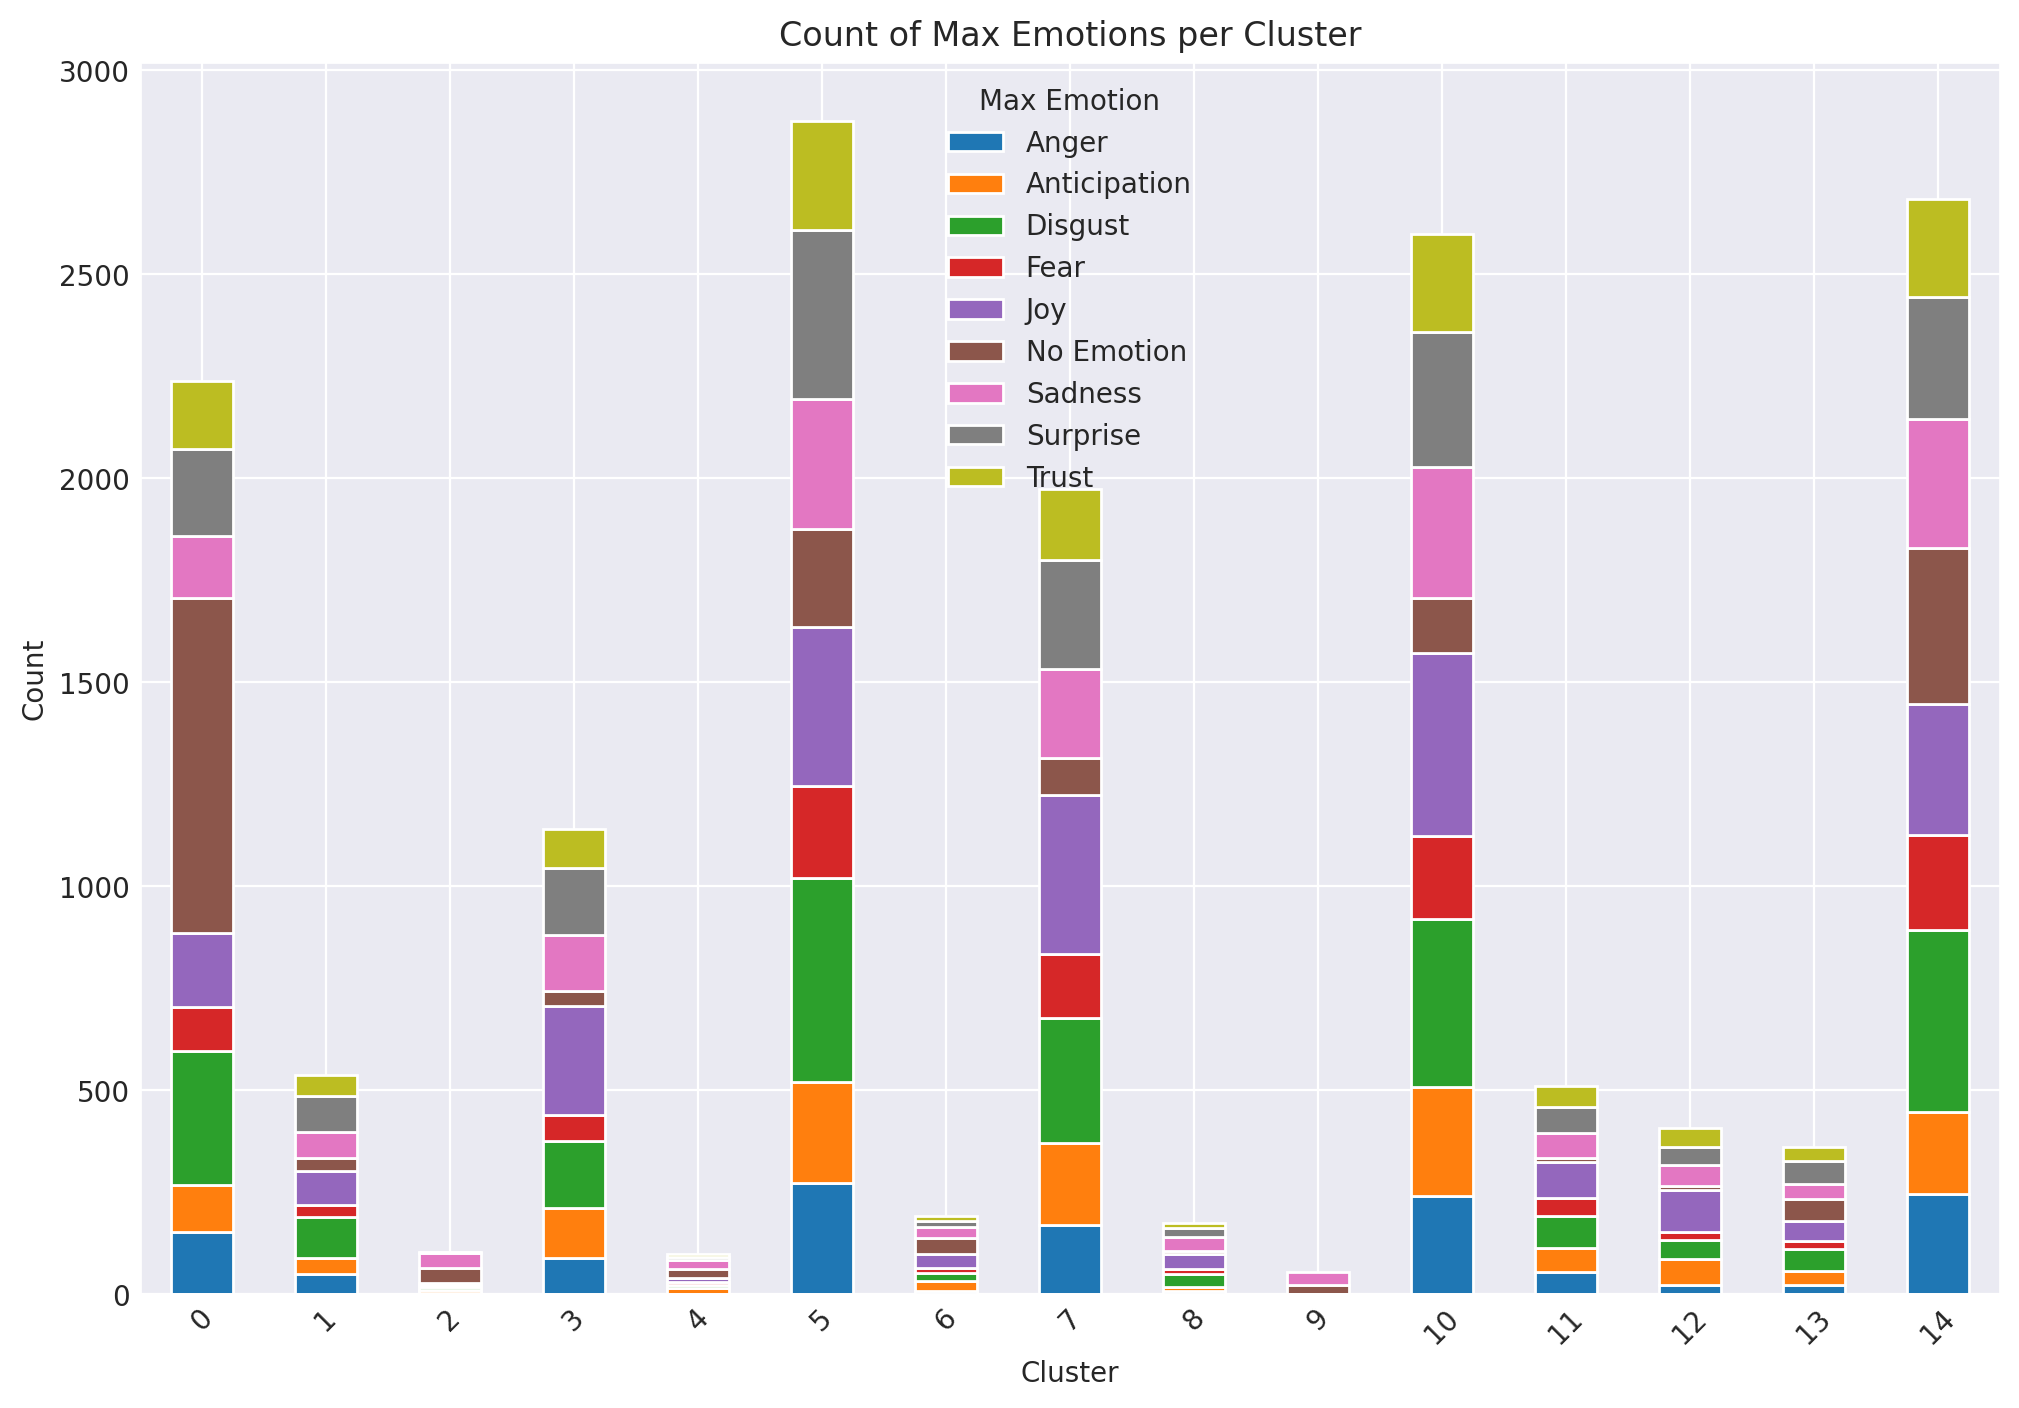

In [ ]:
import matplotlib.pyplot as plt

# Grouping by clusters and max_emotion, then counting occurrences
emotion_counts = forum.groupby(['clusters', 'max_emotion']).size().unstack(fill_value=0)

# Plotting
emotion_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Count of Max Emotions per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Max Emotion')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Create an empty DataFrame to store the calculated values
cluster_sentiments = pd.DataFrame(columns=['clusters'] + list(forum.iloc[0]['scaled_emotional_scores'].keys()))

# Add all clusters from 0 to 14 to the DataFrame
cluster_sentiments['clusters'] = range(15)

In [ ]:
# Iterate over each row in the forum DataFrame
for index, row in forum.iterrows():
    # Get the cluster number for the current row
    cluster = row['clusters']

    # Iterate over each emotion and its corresponding value in the scaled_emotional_scores
    for emotion, value in row['scaled_emotional_scores'].items():
        # Add the value of the emotion to the corresponding cluster
        if emotion in cluster_sentiments.columns:
            cluster_sentiments.loc[cluster_sentiments['clusters'] == cluster, emotion] = cluster_sentiments.loc[cluster_sentiments['clusters'] == cluster, emotion].fillna(0) + value


    clusters     Anger Anticipation   Disgust      Fear       Joy   Sadness  \
0          0  0.031355     0.025079  0.035947  0.029773  0.023812  0.026809   
1          1  0.028216     0.027223  0.030632  0.028919  0.027154  0.029163   
2          2  0.000421     0.001795  0.000579   0.00203  0.000579   0.00226   
3          3  0.141424     0.158577  0.137947  0.139449  0.169815  0.145534   
4          4  0.001685     0.003191  0.002579  0.003266  0.002158  0.003453   
5          5  0.159686     0.148057  0.156421  0.158454  0.137531  0.152566   
6          6  0.005628     0.007255  0.006158  0.006443  0.006841  0.007817   
7          7  0.187634     0.188268  0.181737  0.186049  0.195443  0.184586   
8          8  0.017764     0.016778  0.019737  0.017858  0.018629    0.0194   
9          9  0.000038     0.000922       0.0  0.001147       0.0  0.001224   
10        10  0.196172     0.192531  0.190842  0.201671  0.187865  0.195793   
11        11  0.044449     0.045247  0.044263  0.042

In [ ]:
# Reset font family to default (before we tried setting another one for printing emojis and was giving errors)
plt.rcParams['font.family'] = 'sans-serif'

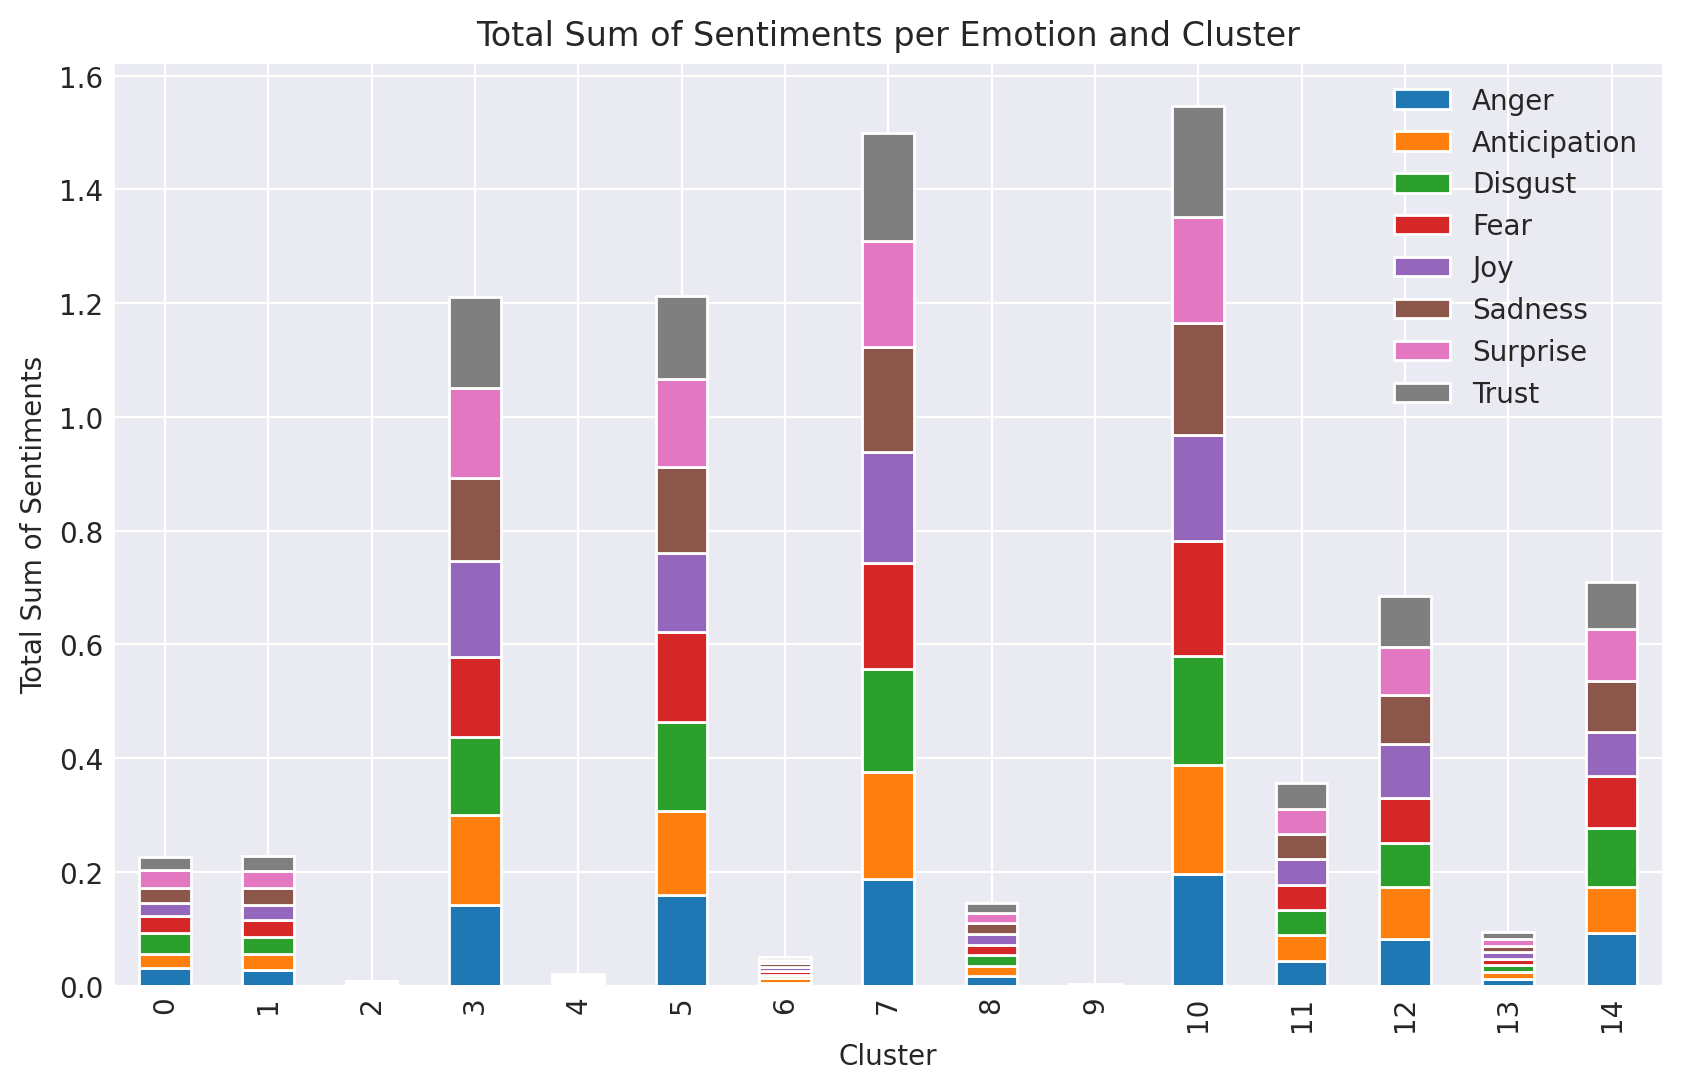

In [ ]:
# Convert data to numeric
cluster_sentiments = cluster_sentiments.apply(pd.to_numeric, errors='coerce')

# Plot
cluster_sentiments.set_index('clusters').plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Total Sum of Sentiments')
plt.title('Total Sum of Sentiments per Emotion and Cluster')
plt.show()

The conclusion that can be drawn from this is that the clusters are all well representated with all the emotions in our dataset.

# Pipeline for new text and emoji recommendation based on sentiment analysis

The goal of this pipeline is to implement part of the project in the interactive dashboard.

Given a new str text, will recomend three emojis based on the sentiment analysis. The output will be the table with all the process applied.

Again, we will recall some variables that ahve been created on another run of this notebook. In specific the tfidf matrix.

In [ ]:
tfidf_sparse_loaded = sparse.load_npz('tfidf_matrix.npz')
svd_loaded = load('svd_model.pkl')

In [ ]:
def recommending_emojis(text):
    """
    Recommend emojis based on text sentiment and emotional content.

    Args:
    - text (str): The input text for which emojis are to be recommended.

    Returns:
    - df_new (DataFrame): A DataFrame containing the input text, emotional scores, sentiment analysis results,
                          and recommended emojis.
    """
    # 1. Cleaning the text
    cleaned_text = clean_text(text)

    # 2. Clustering (tfidf, svd, kmeans)
    tfidf_svd_loaded = svd_loaded.transform(tfidf_sparse_loaded)

    predicted_labels = kmeans.predict(tfidf_svd_loaded)
    cluster = predicted_labels[0]

    # 3. Sentiment analysis

    # 3.1. NRC Lexicon
    emotional_scores = calculate_emotional_scores(cleaned_text)
    df_new = pd.DataFrame({'clean_text': [new_text], 'emotional_scores': [emotional_scores]})

    # 3.2. Scaling emotional scores
    total_emotions, scaled_emotional_scores = scale_emotional_scores(df_new['emotional_scores'], total_emotions=total_emotions_for_new_text)
    df_new["scaled_emotions_NRC"] = scaled_emotional_scores

    # 3.3. Vader
    df_new['emotions_vader'] = df_new['clean_text'].apply(get_sentiment_label)

    # 3.4. Emojis for the emotions (positive forum with positive emojis, etc...)
    df_new_scores = np.array([list(doc['scaled_emotions_NRC'].values()) for _, doc in df_new.iterrows() if doc['scaled_emotions_NRC']])
    if df_new.iloc[0]['emotions_vader'] == 'positive':
        selected_emojis = emojis_faces[emojis_faces['sentiment'] == 'positive']
    elif df_new.iloc[0]['emotions_vader'] == 'negative':
        selected_emojis = emojis_faces[emojis_faces['sentiment'] == 'negative']
    elif df_new.iloc[0]['emotions_vader'] == 'neutral':
        selected_emojis = emojis_faces[emojis_faces['sentiment'] == 'neutral']

    # compute the scores of the corresponding emojis
    # compute the scores of the corresponding emojis
    emoji_scores = np.array([list(emoji['scaled_emotional_scores'].values()) for _, emoji in selected_emojis.iterrows()])

    # the following line is for the pipeline in the dashboard, because dicitonary were in str format
    # emoji_scores = np.array([list(ast.literal_eval(emoji['scaled_emotional_scores']).values()) for _, emoji in selected_emojis.iterrows()])

    # using cosine similarity
    similarities = cosine_similarity(df_new_scores, emoji_scores)
    # extracting top 3 emojis
    top_3_indices = np.apply_along_axis(lambda x: top_n_indices(x, 3), axis=1, arr=similarities)
    top_3_emojis = [[selected_emojis.iloc[idx]['emoji'] for idx in indices] for indices in top_3_indices]
    top_3_emojis_str = [','.join(emojis) for emojis in top_3_emojis]
    # adding them to a column
    df_new['Emojis Sentiment Analysis'] = top_3_emojis_str

    return df_new

In [ ]:
new_text = "i am happy we saw today, it was amazing"
df_new = recommending_emojis(new_text)
df_new

clean_text  \
0  i am happy we saw today, it was amazing   

                                    emotional_scores  \
0  {'Anger': 0, 'Anticipation': 1, 'Disgust': 0, ...   

                                 scaled_emotions_NRC emotions_vader  \
0  {'Anger': 0.0, 'Anticipation': 2.4929573953581...       positive   

  Emojis Sentiment Analysis  
0                     😀,😄,😙

In [ ]:
new_text = "i am sad because my cat died yesterday"
df_new = recommending_emojis(new_text)
df_new

clean_text  \
0  i am sad because my cat died yesterday   

                                    emotional_scores  \
0  {'Anger': 1, 'Anticipation': 0, 'Disgust': 1, ...   

                                 scaled_emotions_NRC emotions_vader  \
0  {'Anger': 3.8284839203675343e-05, 'Anticipatio...       negative   

  Emojis Sentiment Analysis  
0                     😨,😞,😧

## Exporting our final dataset forum

In [ ]:
forum.to_csv("forum.csv", index = False)

In [ ]:
emojis_faces.to_csv("emojis_faces.csv", index = False)